# 0 **Imports**

In [361]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import scikitplot          as skplt
import matplotlib.gridspec as gridspec
import xgboost             as xgb
import lightgbm            as lightgbm
import warnings;warnings.filterwarnings("ignore")

from pylab                   import rcParams
from matplotlib              import pyplot           as plt
from scipy                   import stats            as ss
from sklearn                 import model_selection  as ms
from sklearn                 import preprocessing    as pp
from sklearn                 import ensemble         as en
from sklearn                 import linear_model     as lm
from sklearn                 import neighbors        as nh
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import top_k_accuracy_score
from sklearn.metrics         import accuracy_score, f1_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

##  **0.1 Helper functions**

In [362]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

## **0.2 Loading data**

In [363]:
df_insurance_raw=pd.read_csv('../data/insurance_202206101822.csv')
df_users_raw=pd.read_csv('../data/users_202206101824.csv')
df_vehicles_raw=pd.read_csv('../data/vehicle_202206101824.csv')

# merge
df_raw=pd.merge(df_insurance_raw,df_users_raw,how='left',on='id')
df_raw=pd.merge(df_raw,df_vehicles_raw,how='left',on='id')

## 0.3 Test separation

In [364]:
df_raw

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,40454.0,217,1,Male,44,28.0,26.0,1,> 2 Years,Yes
1,2,0,33536.0,183,0,Male,76,3.0,26.0,1,1-2 Year,No
2,3,0,38294.0,27,1,Male,47,28.0,26.0,1,> 2 Years,Yes
3,4,1,28619.0,203,0,Male,21,11.0,152.0,1,< 1 Year,No
4,5,1,27496.0,39,0,Female,29,41.0,152.0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,30170.0,88,0,Male,74,26.0,26.0,1,1-2 Year,No
381105,381106,1,40016.0,131,0,Male,30,37.0,152.0,1,< 1 Year,No
381106,381107,1,35118.0,161,0,Male,21,30.0,160.0,1,< 1 Year,No
381107,381108,0,44617.0,74,0,Female,68,14.0,124.0,1,> 2 Years,Yes


In [365]:
# X=df_raw.drop('response',axis=1)
# y=df_raw['response'].copy()

# x_train, x_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.20,random_state=42)

# df_raw=pd.concat ([x_train, y_train], axis=1) 

# df_raw=df_raw.reset_index(drop=True)

# **Step 1 Data description**

In [366]:
df1=df_raw.copy()

In [367]:
df1

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,40454.0,217,1,Male,44,28.0,26.0,1,> 2 Years,Yes
1,2,0,33536.0,183,0,Male,76,3.0,26.0,1,1-2 Year,No
2,3,0,38294.0,27,1,Male,47,28.0,26.0,1,> 2 Years,Yes
3,4,1,28619.0,203,0,Male,21,11.0,152.0,1,< 1 Year,No
4,5,1,27496.0,39,0,Female,29,41.0,152.0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,30170.0,88,0,Male,74,26.0,26.0,1,1-2 Year,No
381105,381106,1,40016.0,131,0,Male,30,37.0,152.0,1,< 1 Year,No
381106,381107,1,35118.0,161,0,Male,21,30.0,160.0,1,< 1 Year,No
381107,381108,0,44617.0,74,0,Female,68,14.0,124.0,1,> 2 Years,Yes


## **1.1 Data types**

In [368]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## **1.2 Change types**

In [369]:
df1['region_code']=df1['region_code'].astype('int64')
df1['policy_sales_channel']=df1['policy_sales_channel'].astype('int64')

## **1.3 Check NA**

In [370]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

In [371]:
x_test.isna().sum()

id                          0
previously_insured          0
annual_premium              0
vintage                     0
age                         0
region_code                 0
policy_sales_channel        0
driving_license             0
vehicle_damage              0
response                    0
gender_Female               0
gender_Male                 0
vehicle_age_below_1_year    0
dtype: int64

## **1.4 Descriptive statistics**

In [372]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### **1.4.1 Numerical attributes**

In [373]:
# Central Tendency - mean, median 
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min () )).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
3,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
4,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
5,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
6,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


### **1.4.2 Categorical attributes**

In [374]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

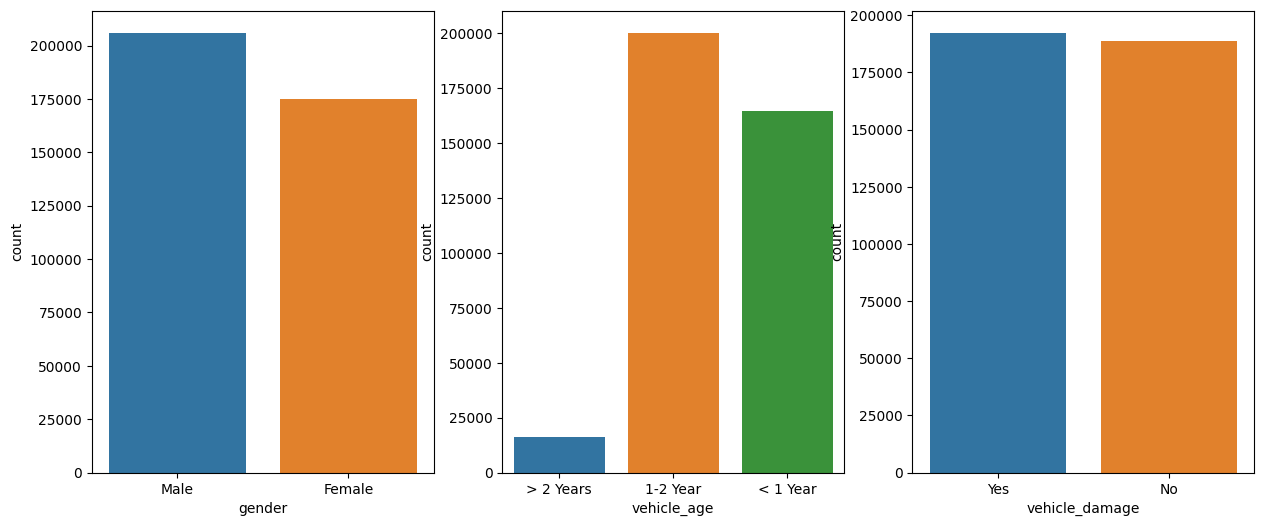

In [375]:
rcParams['figure.figsize'] = 15,6

plt.subplot(1,3,1);
sns.countplot(x='gender',data=df1);

plt.subplot(1,3,2);
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(1,3,3);
sns.countplot(x='vehicle_damage',data=df1);

# **Step 2 Feature engineering**

In [376]:
df2=df1.copy()

In [377]:
# vehicle age
df2['vehicle_age']=df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')

# previously insured
df2['previously_insured']=df2['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

# driving license
df2['driving_license']=df2['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')

# **Step 3 Variable filtering**

In [378]:
df3=df2.copy()

## <s>**3.1 Row filtering**<s/>

## <s>**3.2 Column filtering**<s/>

# **Step 4 Exploratory data analysis**

In [379]:
df4=df3.copy()

## **4.1 Univariate analysis**

### **4.1.1 Response variable**

response
0    334399
1     46710
Name: count, dtype: int64

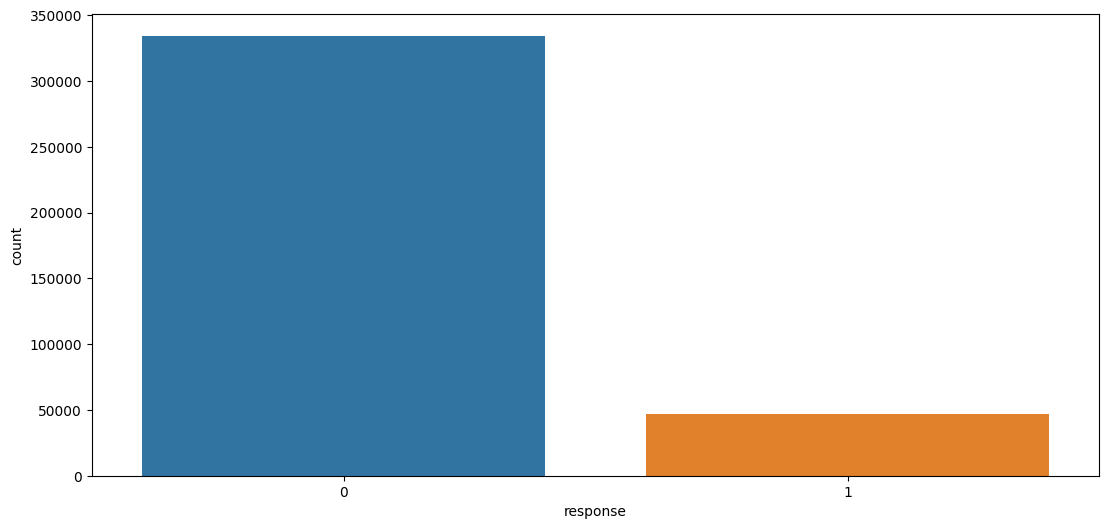

In [183]:
rcParams['figure.figsize'] = 13,6

sns.countplot(x='response',data=df4);
df4['response'].value_counts()

### **4.1.2 Numerical variables**

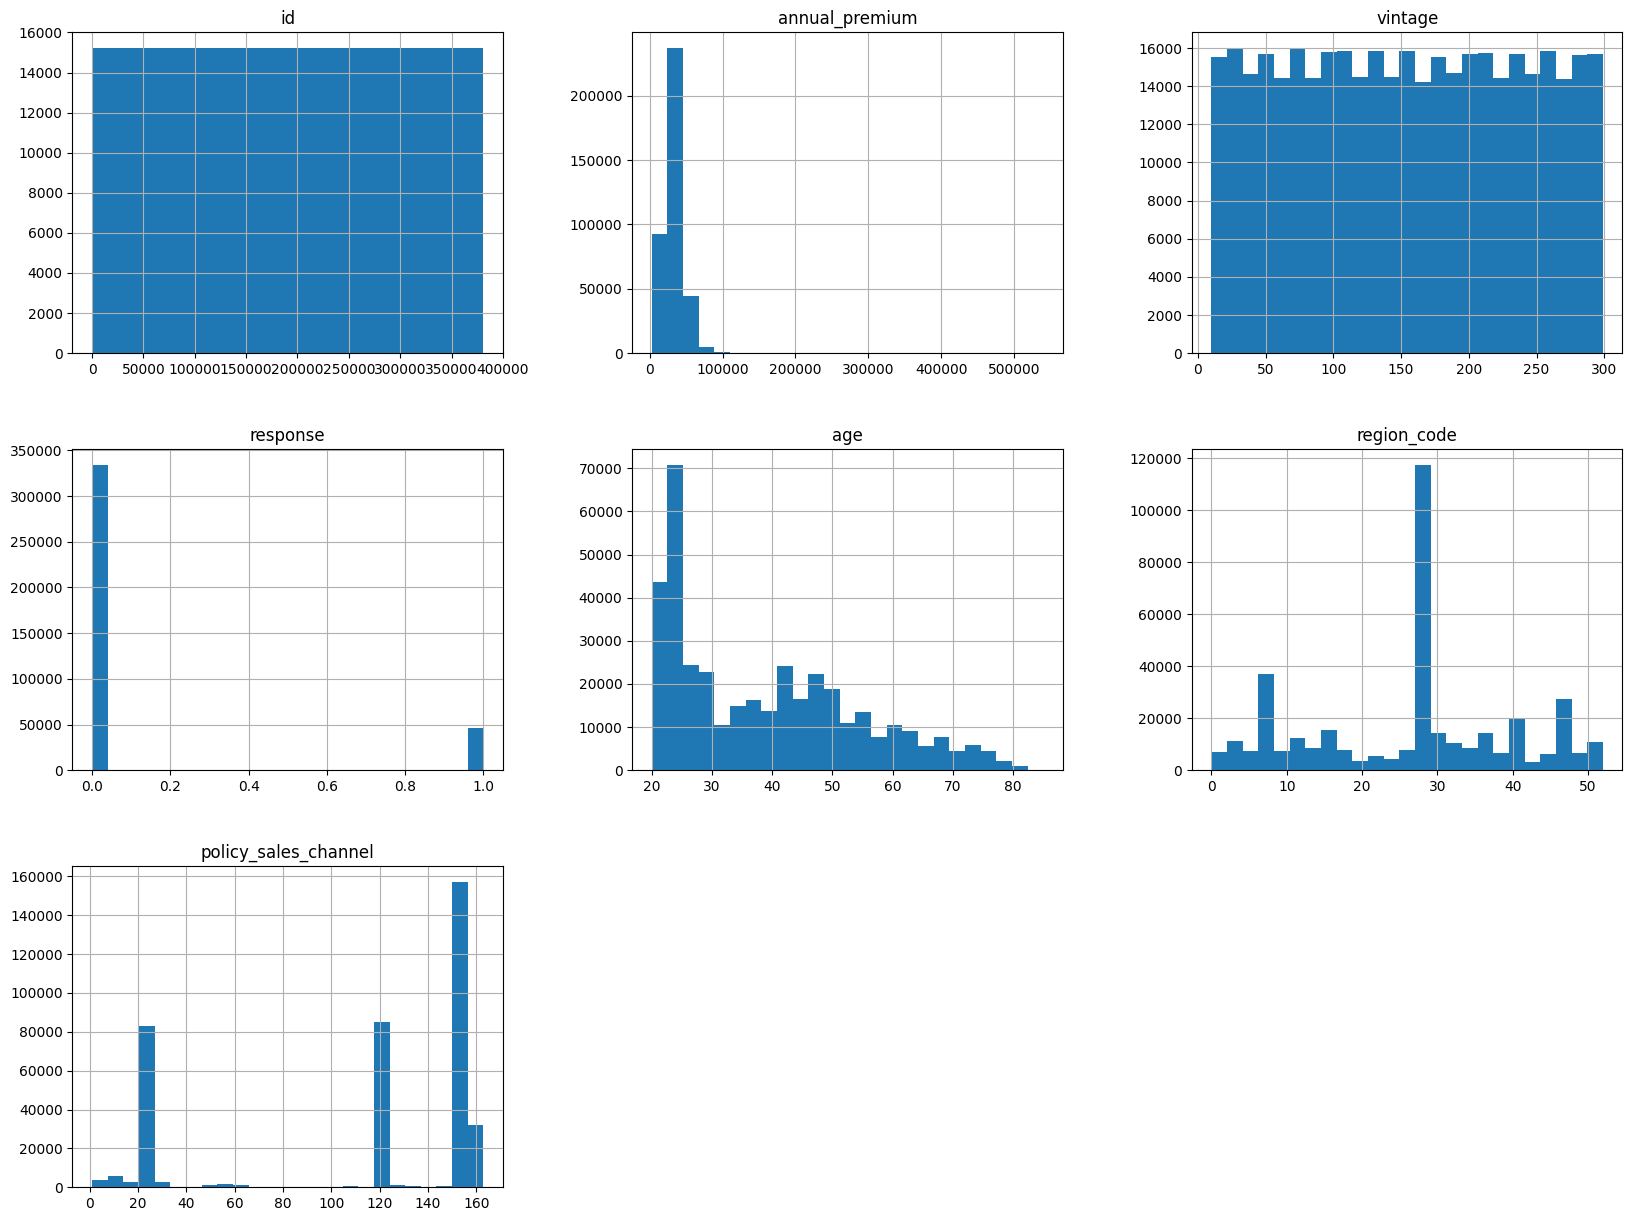

In [184]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64'])

rcParams['figure.figsize'] = 20,15
num_attributes.hist(bins=25);

### **4.1.3 Categorical variables**

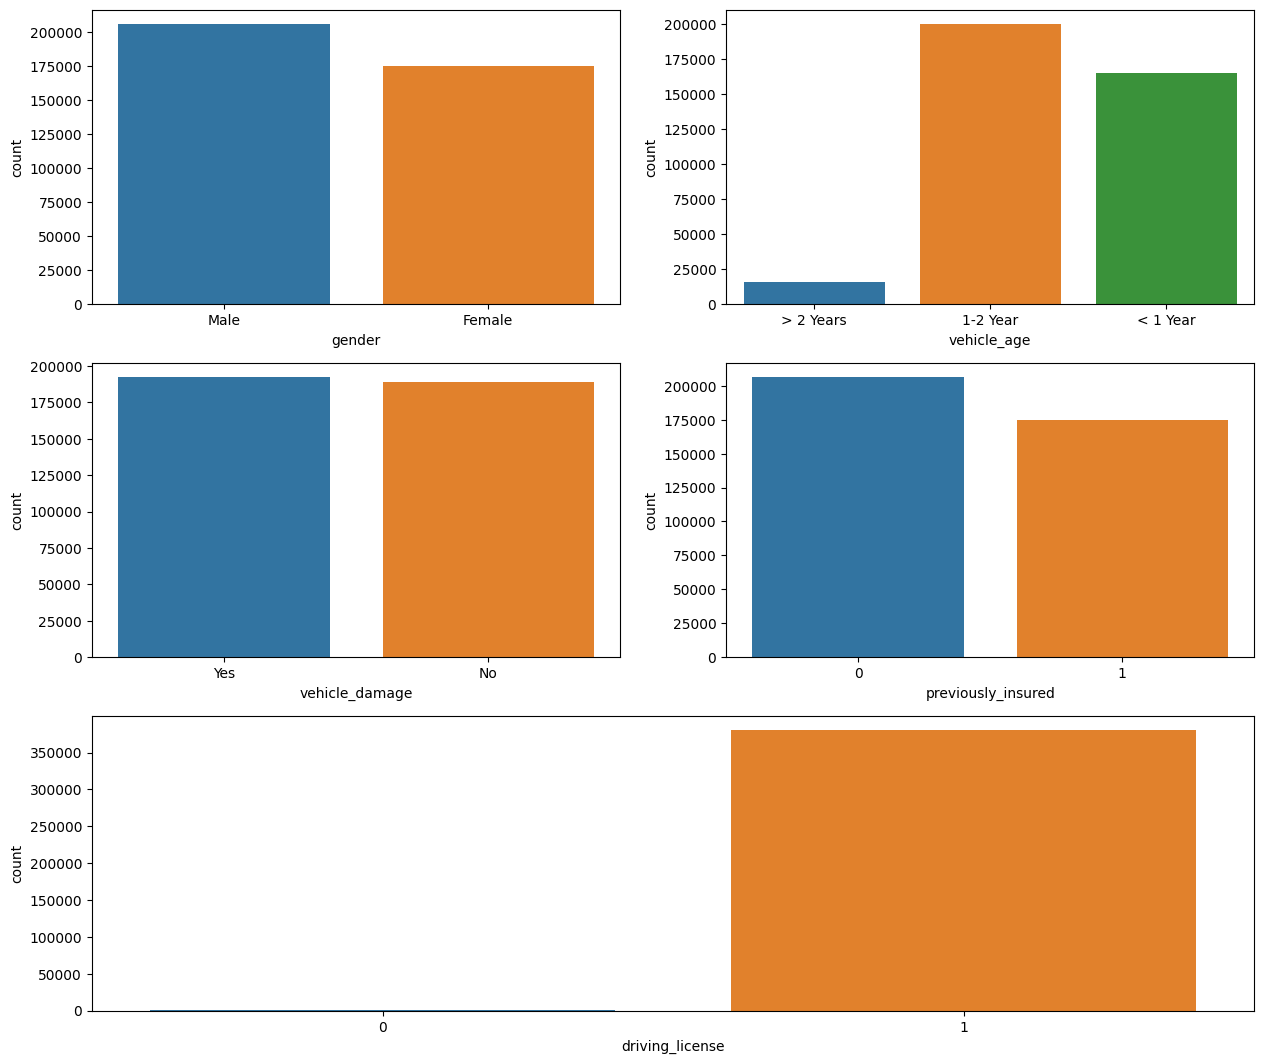

In [185]:
rcParams['figure.figsize'] = 15,13

grid=gridspec.GridSpec(3,2)

plt.subplot(grid[0,0])
sns.countplot(x='gender',data=df1);

plt.subplot(grid[0,1])
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(grid[1,0])
sns.countplot(x='vehicle_damage',data=df1);

plt.subplot(grid[1,1])
sns.countplot(x='previously_insured',data=df1);

plt.subplot(grid[2,:])
sns.countplot(x='driving_license',data=df1);

## **4.2 Bivariate analysis**


### **4.2.1 Annual_premium**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


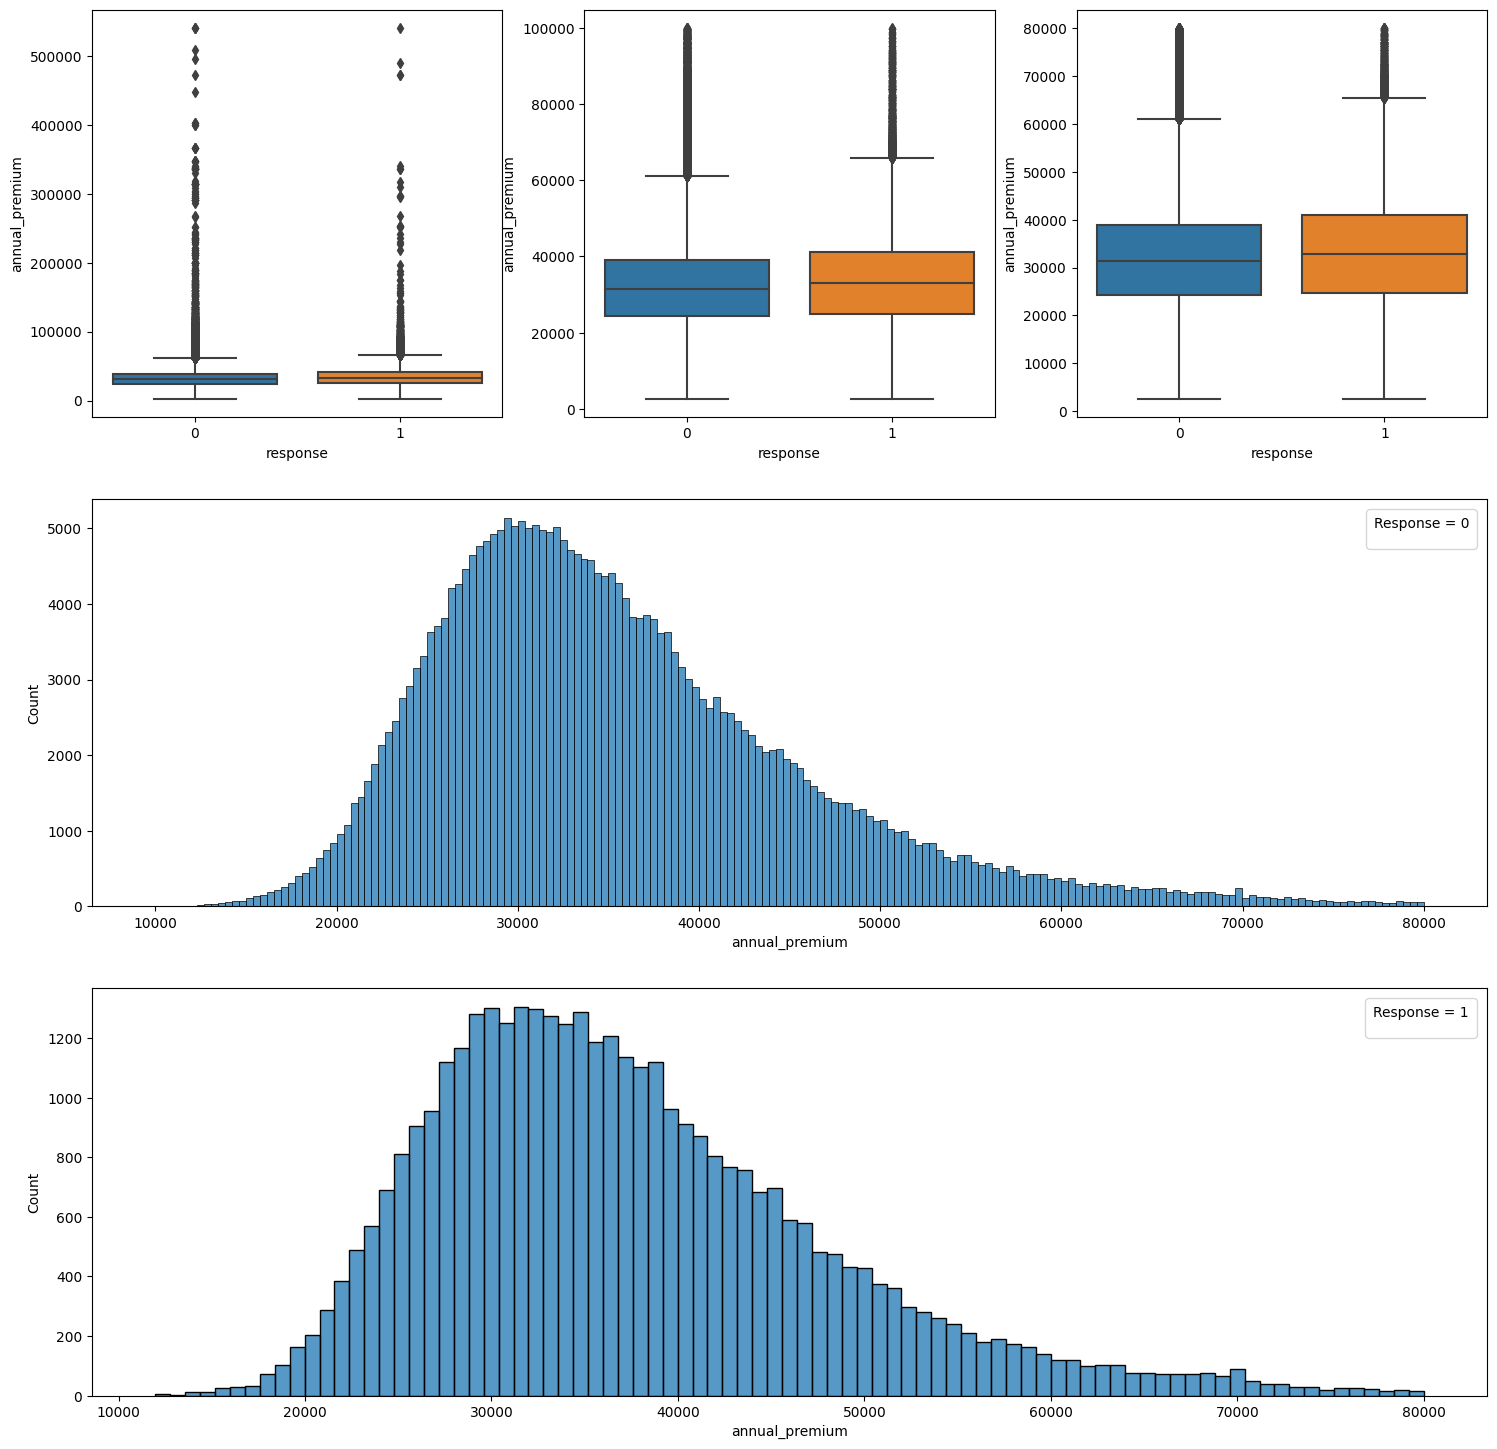

In [186]:
rcParams['figure.figsize'] = 18,18
grid=gridspec.GridSpec(3,3)


plt.subplot(grid[0,0])
sns.boxplot(x='response',y='annual_premium',data=df4); 

aux4=df4[df4['annual_premium'] < 100000]
plt.subplot(grid[0,1])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux4=df4[df4['annual_premium'] < 80000]
plt.subplot(grid[0,2])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']     
plt.subplot(grid[1,:])

plt.legend(title='Response = 0', fontsize="x-large")
sns.histplot(aux00);

aux00=aux.loc[df4['response']==1,'annual_premium'] 
plt.subplot(grid[2,:])
plt.legend(title='Response = 1', fontsize="x-large")
sns.histplot(aux00);

### **4.2.2 Vintage**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


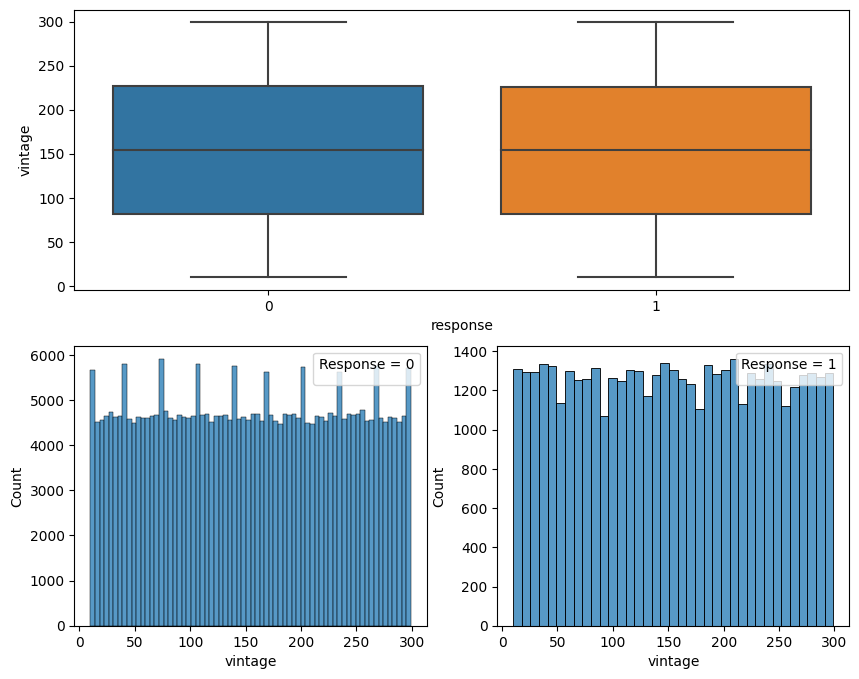

In [187]:
rcParams['figure.figsize'] = 10,8

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,:])
sns.boxplot(x='response',y='vintage',data=df4);

plt.subplot(grid[1,0])
plt.legend(title='Response = 0')
sns.histplot(df4.loc[df4['response']==0,'vintage']);

plt.subplot(grid[1,1])
plt.legend(title='Response = 1')
sns.histplot(df4.loc[df4['response']==1,'vintage']);

### **4.2.3 Age**

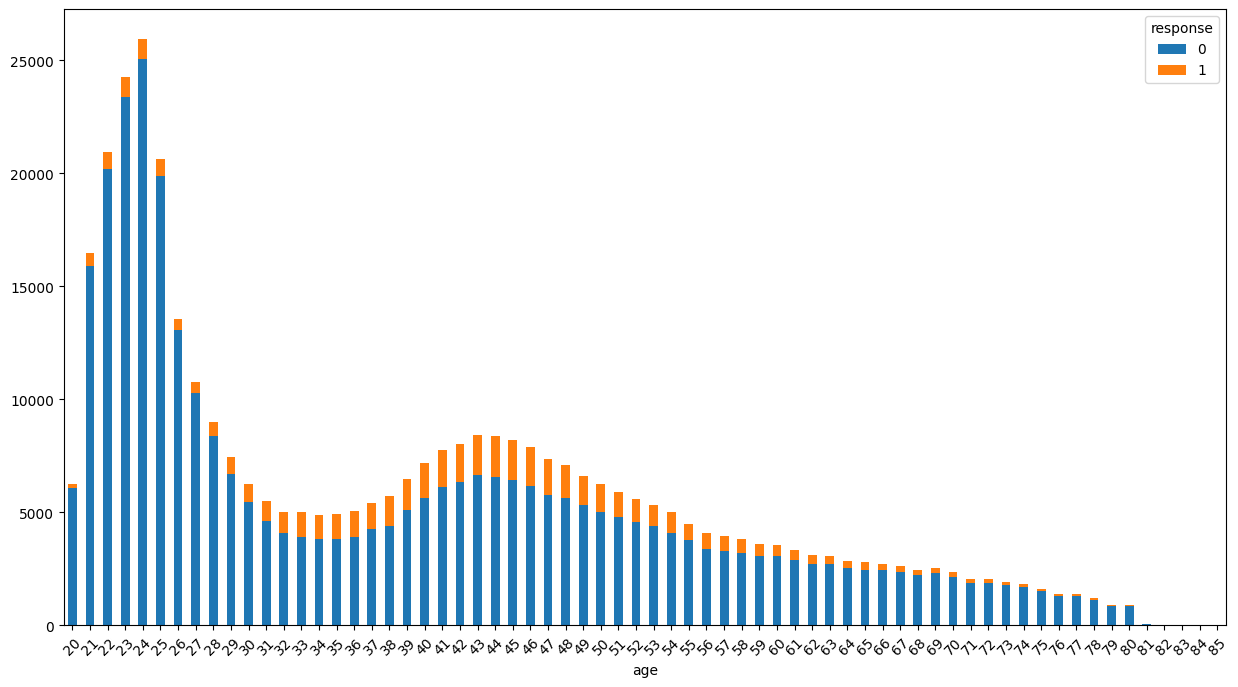

In [188]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

### **4.2.4 Region_code**

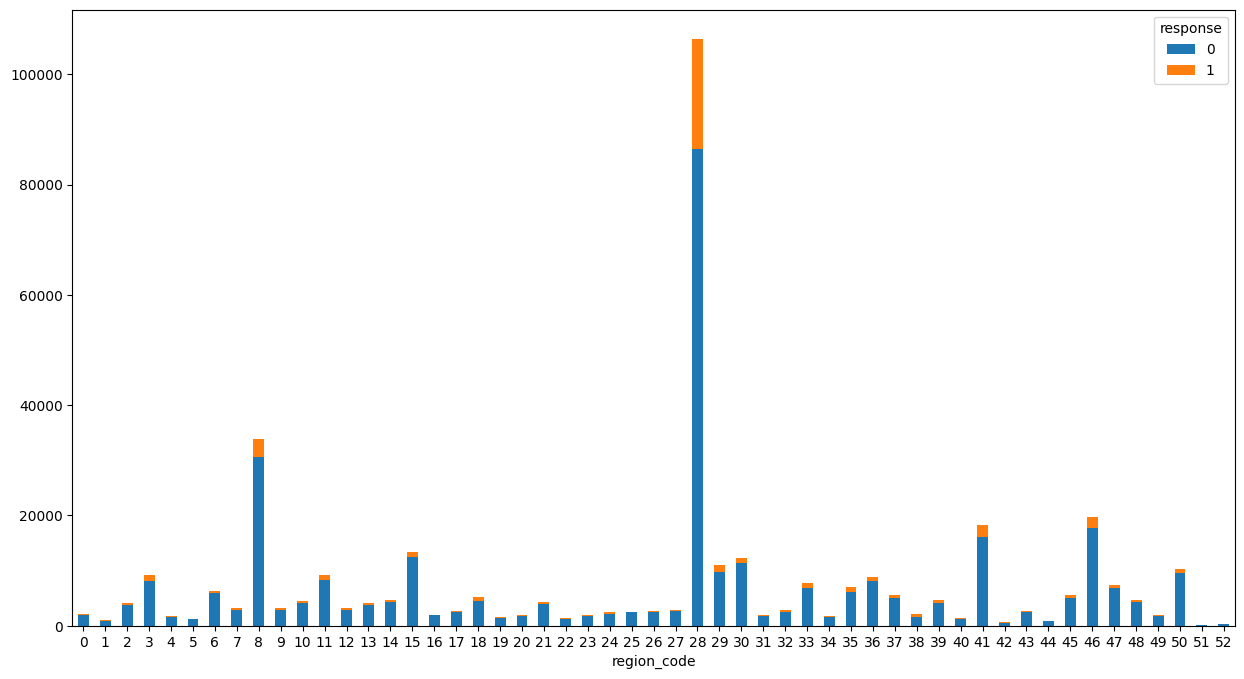

In [189]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['region_code'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [190]:
# rcParams['figure.figsize'] = 15,15

# grid=gridspec.GridSpec(2,2)

# plt.subplot(grid[0,:])
# aux0=df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
# sns.scatterplot(x='region_code',y='id',hue='response',data=aux0);

# # plt.subplot(grid[1,:])
# # sns.boxplot(x='response',y='region_code',data=df4);   # olhar a mediana/quartis/medianas de cada um dos grupos em relação a idade
# # 0 = 35 anos mediana, 1° ao 3° quartil : 25 a 50 anos


# plt.subplot(grid[1,0])
# aux00=df4.loc[df4['response']==0,'region_code']        # loc para passar a coluna como string
# plt.legend(title='Response = 0')
# sns.histplot(aux00);


# plt.subplot(grid[1,1])
# aux00=df4.loc[df4['response']==1,'region_code']        
# plt.legend(title='Response = 1')
# sns.histplot(aux00);

### **4.2.5 Policy_sales_channel**

In [191]:
df4['policy_sales_channel'].value_counts(ascending=True).head(20)

policy_sales_channel
41     1
144    1
143    1
123    1
43     1
149    1
84     1
112    2
75     2
50     2
74     2
34     3
28     3
105    3
27     3
33     3
6      3
102    3
76     4
68     4
Name: count, dtype: int64

In [192]:
aux=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >20]
aux=aux[['policy_sales_channel','response']].groupby(['policy_sales_channel']).value_counts(normalize=True).reset_index()

aux1=aux[(aux['response']==1) & (aux['proportion']<=0.10)] 
aux2=aux[(aux['response']==1) & (aux['proportion']> 0.10) & (aux['proportion']<= 0.20)] 
aux3=aux[(aux['response']==1) & (aux['proportion']>0.20)] 


print(len(aux1))
print(len(aux2))
print(len(aux3))

36
42
16


In [193]:
df=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') <=50]

df1=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >50]
df1=df1[df1.groupby('policy_sales_channel').policy_sales_channel.transform('count') <=100]

df2=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >100]
df2=df2[df2.groupby('policy_sales_channel').policy_sales_channel.transform('count') <=1000]

df3=df4[df4.groupby('policy_sales_channel').policy_sales_channel.transform('count') >1000]

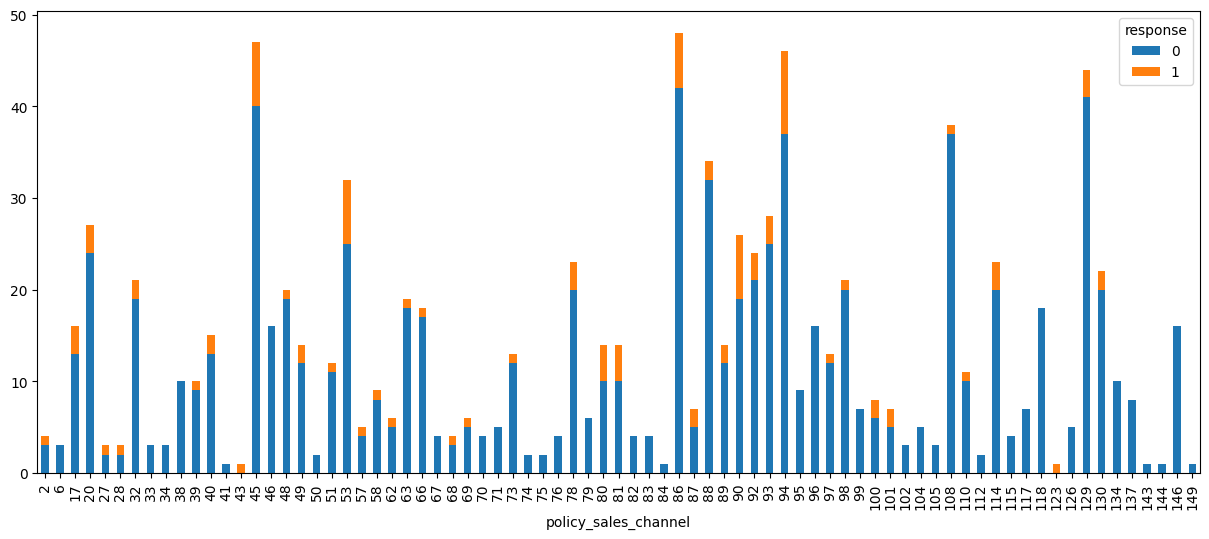

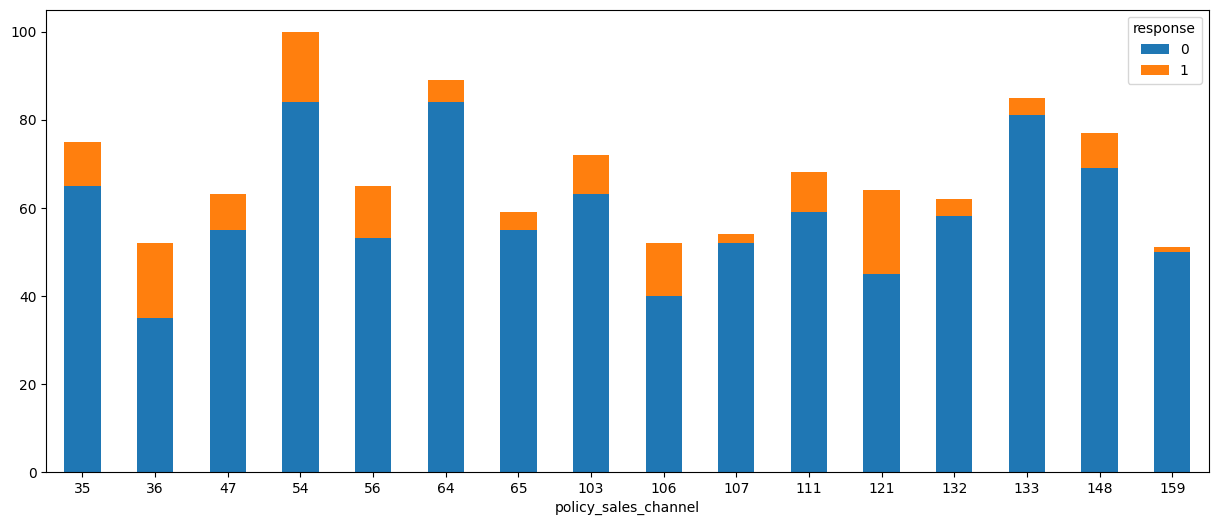

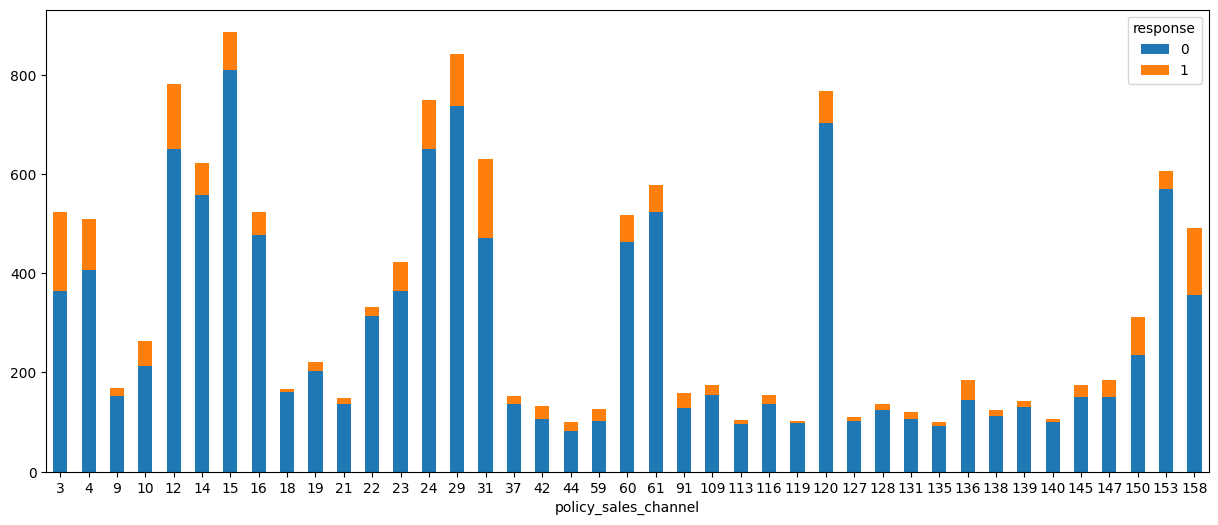

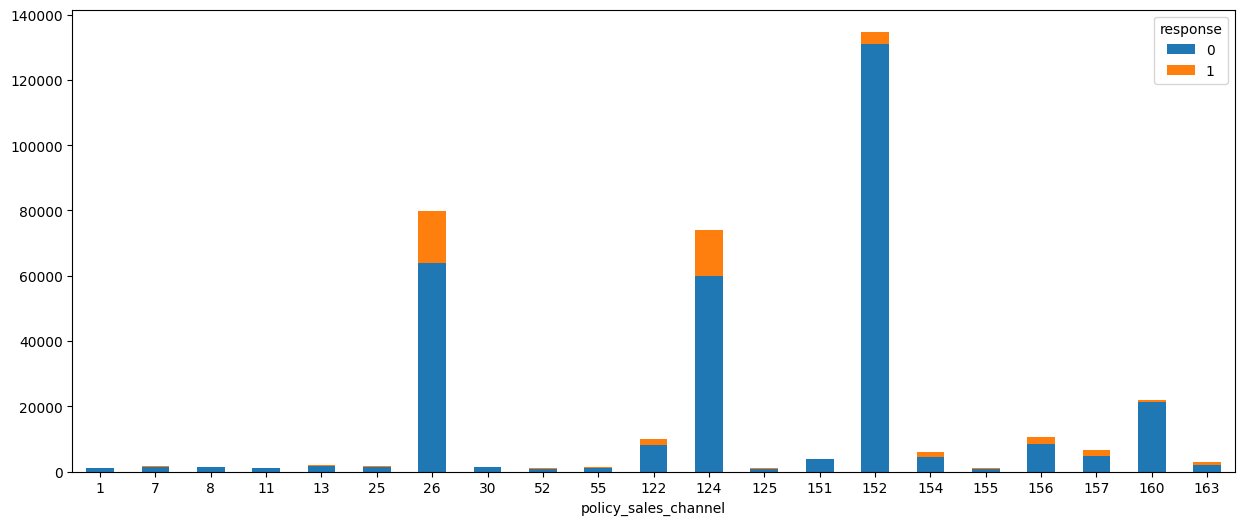

In [194]:
rcParams['figure.figsize'] = 15,6


crosstb=pd.crosstab(df['policy_sales_channel'],df['response'])
pl = crosstb.plot(kind="bar", stacked=True)
plt.xticks(rotation=90);


crosstb=pd.crosstab(df1['policy_sales_channel'],df1['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

crosstb1=pd.crosstab(df2['policy_sales_channel'],df2['response'])
pl = crosstb1.plot(kind="bar", stacked=True, rot=0)


crosstb2=pd.crosstab(df3['policy_sales_channel'],df3['response'])
pl = crosstb2.plot(kind="bar", stacked=True, rot=0)

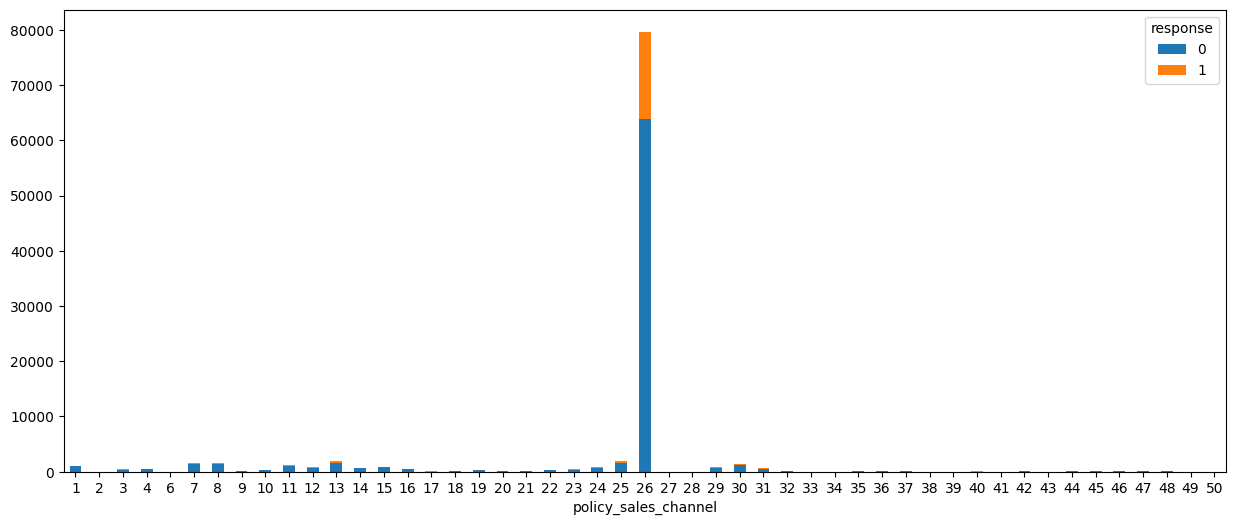

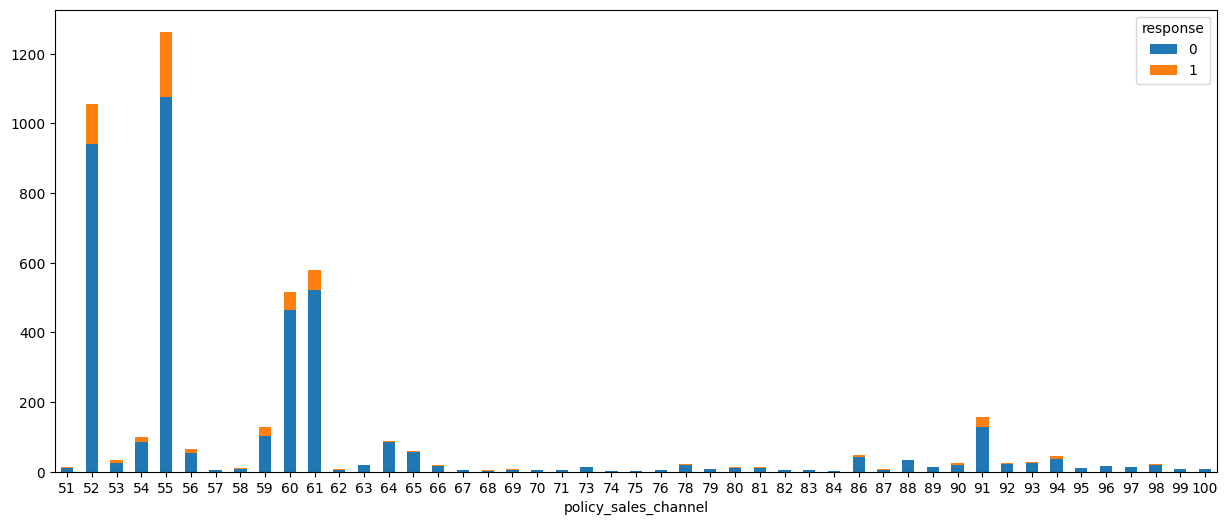

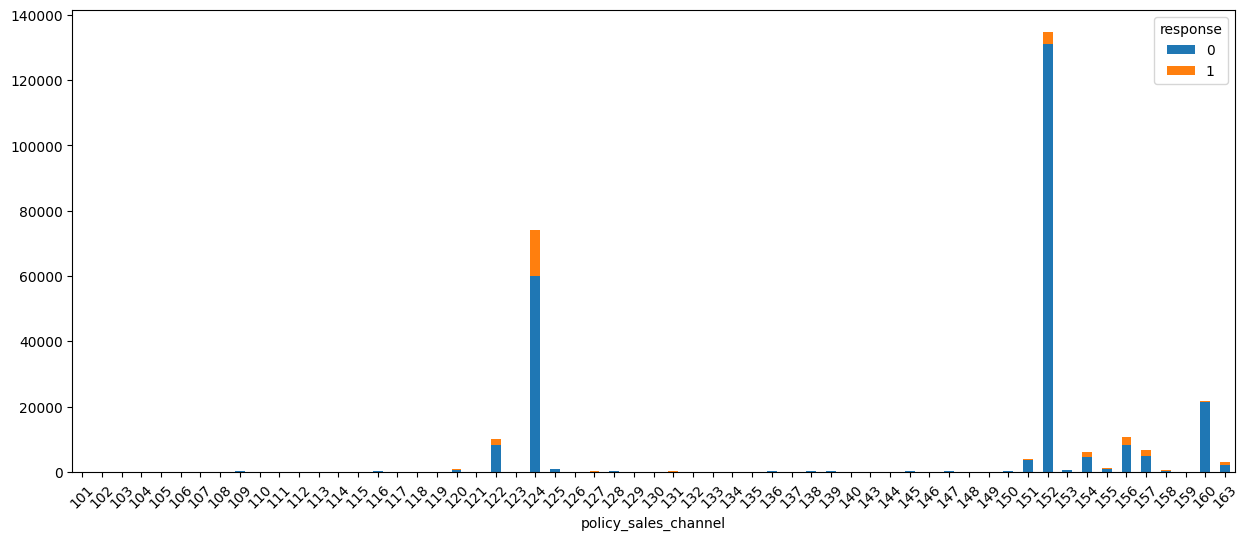

In [195]:
rcParams['figure.figsize'] = 15,6


aux=df4[df4['policy_sales_channel']<=50]
crosstb=pd.crosstab(aux['policy_sales_channel'],aux['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

aux1=df4[(df4['policy_sales_channel']>50) & (df4['policy_sales_channel']<=100)]
crosstb1=pd.crosstab(aux1['policy_sales_channel'],aux1['response'])
pl = crosstb1.plot(kind="bar", stacked=True, rot=0)


aux2=df4[df4['policy_sales_channel']>100]
crosstb2=pd.crosstab(aux2['policy_sales_channel'],aux2['response'])
pl = crosstb2.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

In [196]:
aux=df4[['policy_sales_channel','response']].groupby(['policy_sales_channel']).count().reset_index()
# aux1=aux[aux['response']>10]
aux.head(26)

,policy_sales_channel,response
0,1,1074
1,2,4
2,3,523
3,4,509
4,6,3
5,7,1598
6,8,1515
7,9,169
8,10,264
9,11,1203


### **4.2.6 Vehicle_age**

In [197]:
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


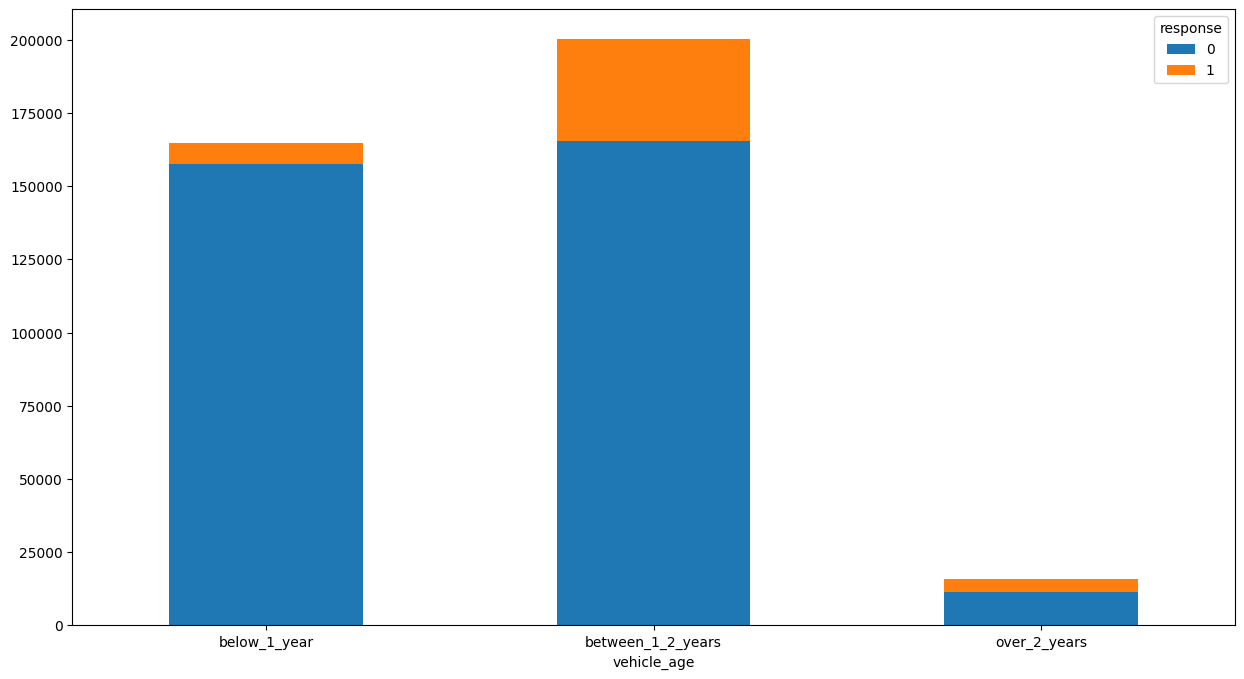

In [198]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.7 Vehicle_damage**

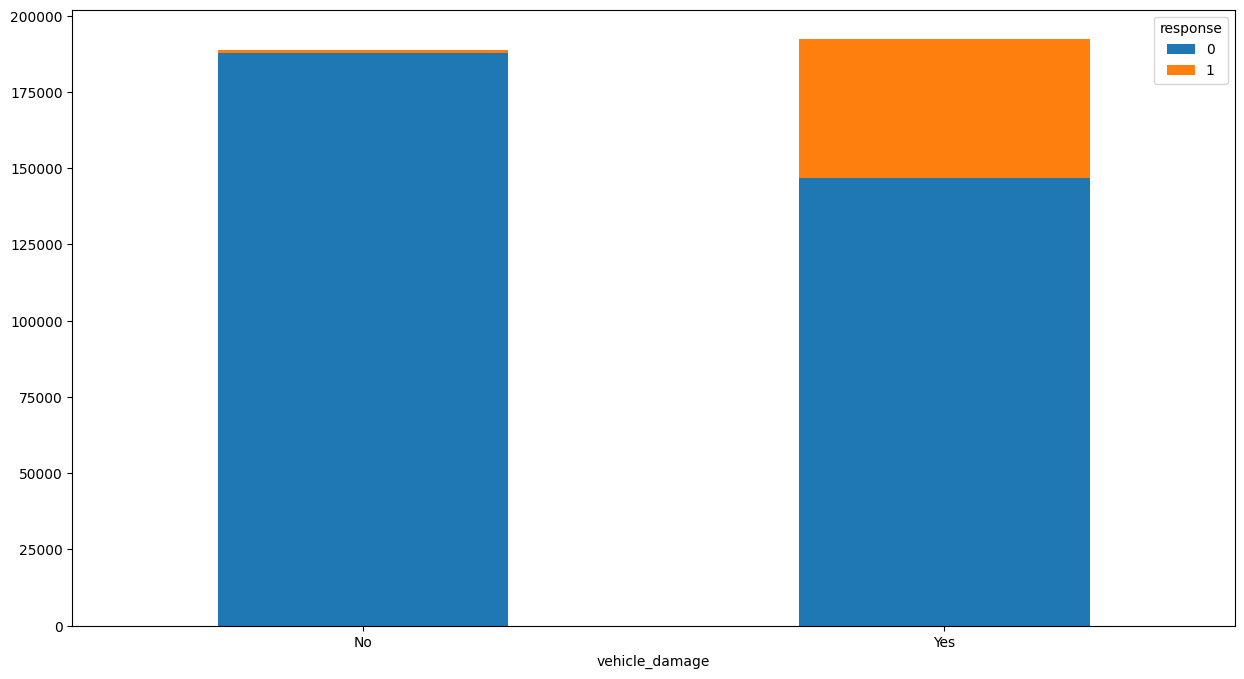

In [199]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_damage'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.8 Previously_insured**

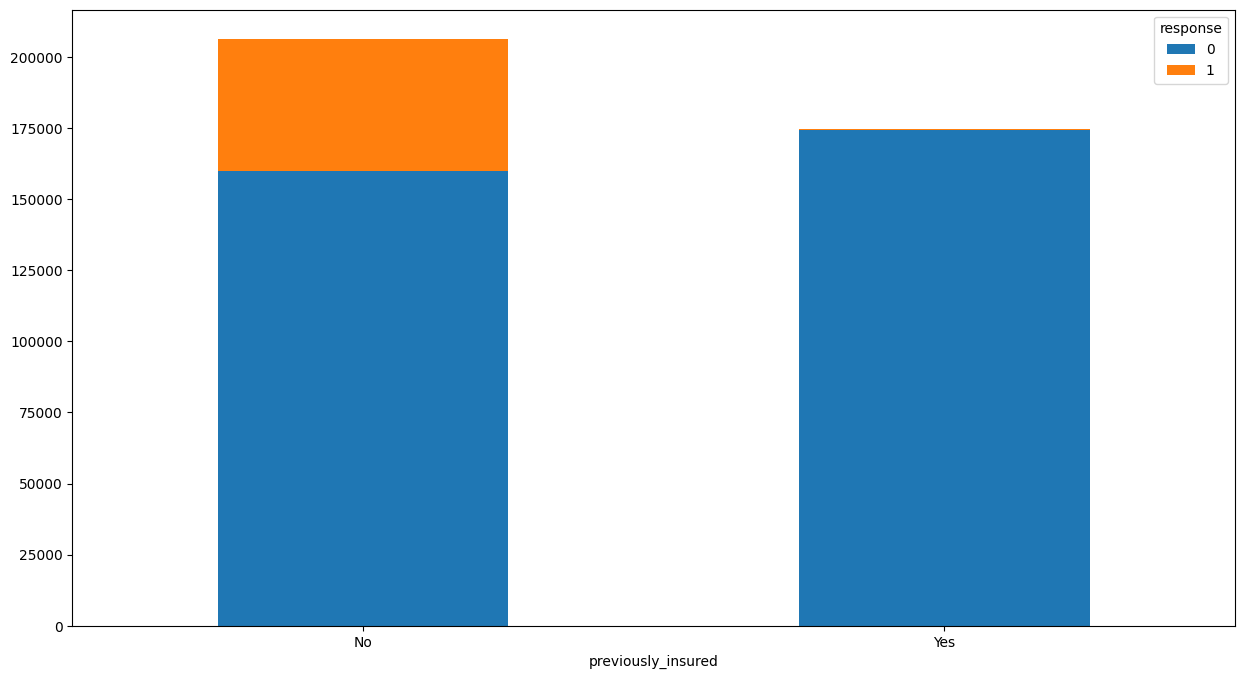

In [200]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['previously_insured'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [201]:
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
previously_insured,,
No,0.774546,0.225454
Yes,0.999095,0.000905


### **4.2.9 Driving_license**

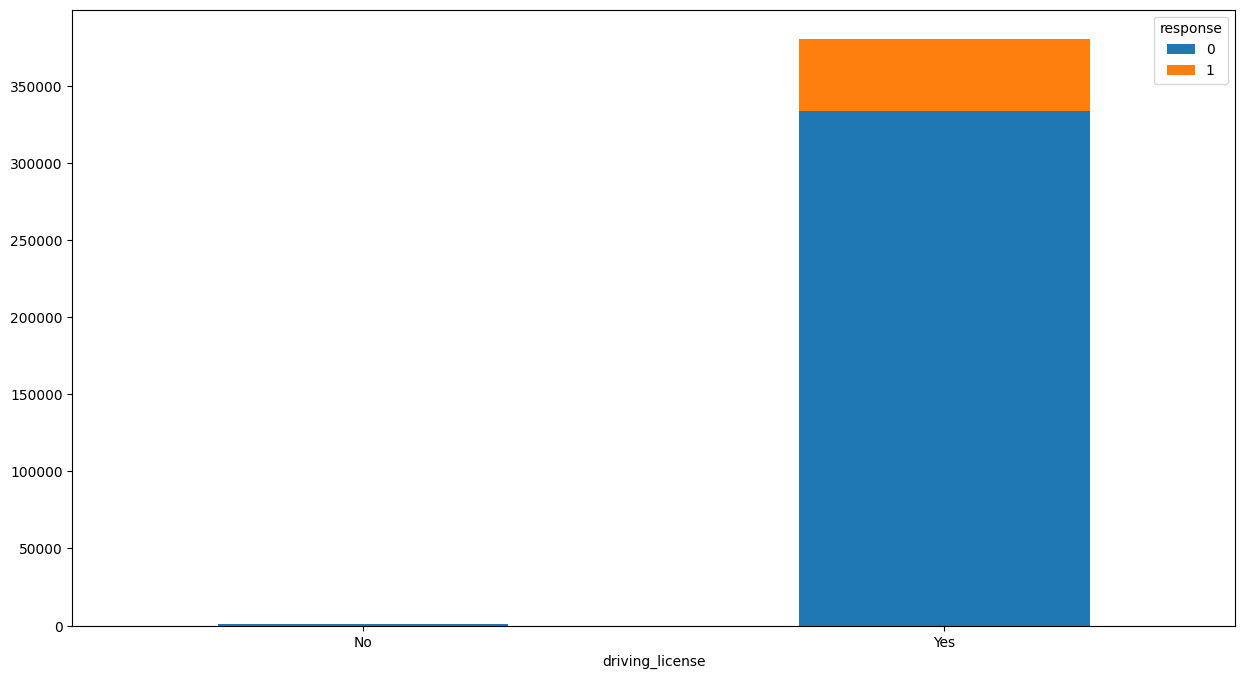

In [202]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['driving_license'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [203]:
pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
driving_license,,
No,0.949507,0.050493
Yes,0.877283,0.122717


### 4.2.10 Gender

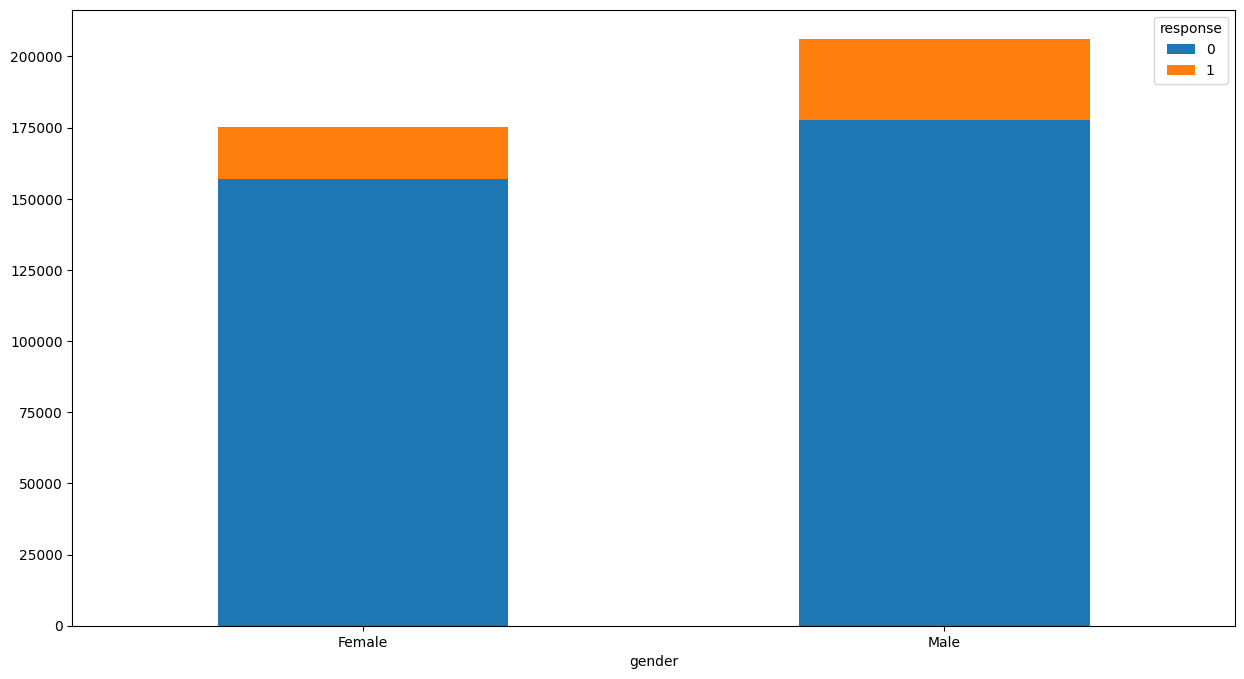

In [204]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['gender'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [205]:
pd.crosstab(df4['gender'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


## **4.3 Multivariate analysis**

### **4.3.1 Numerical attributes**

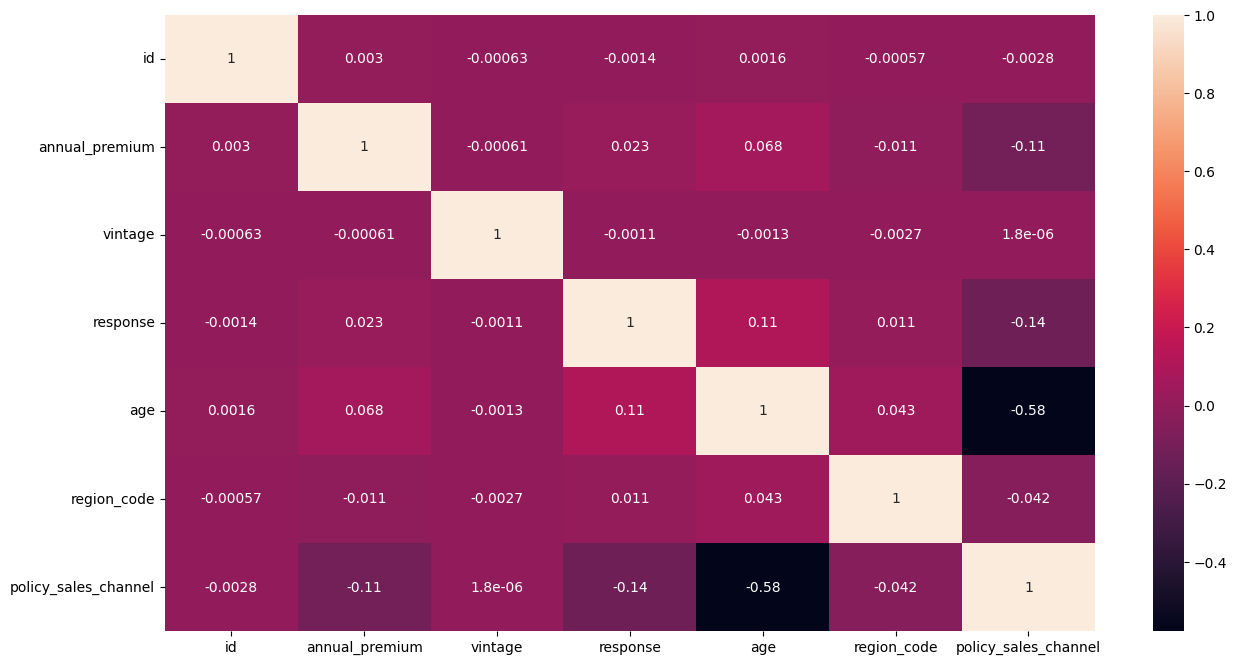

In [206]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### **4.3.2 Categorical attributes**

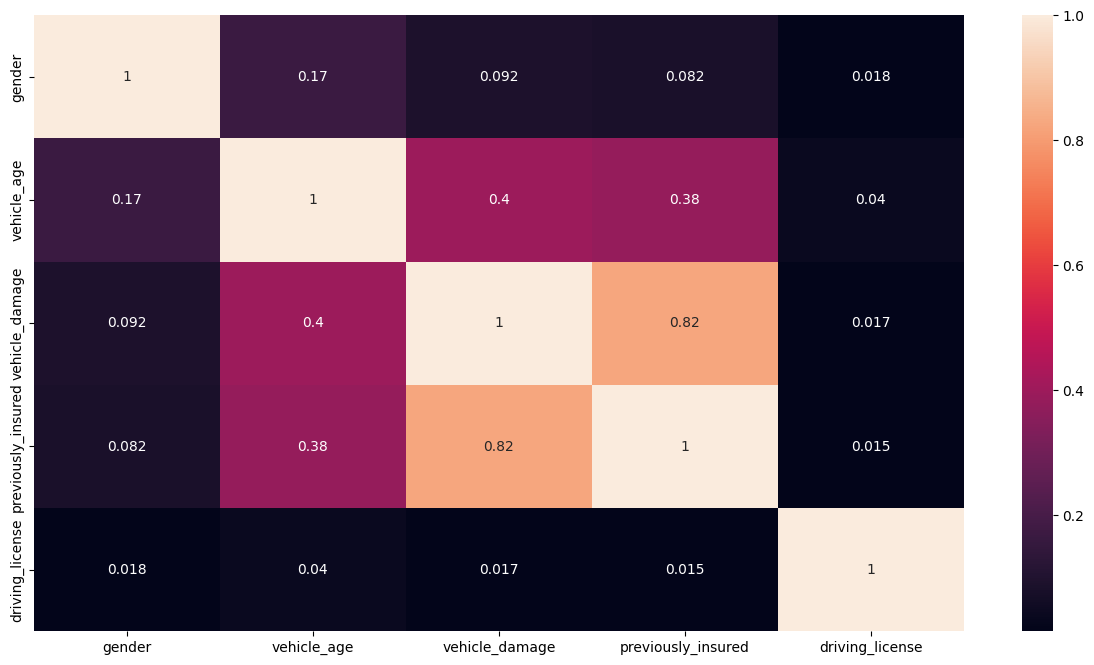

In [207]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )
a4 = cramer_v( a['gender'], a['previously_insured'] )
a5 = cramer_v( a['gender'], a['driving_license'] )

a6 = cramer_v( a['vehicle_age'], a['gender'] )
a7 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a8 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )
a9 = cramer_v( a['vehicle_age'], a['previously_insured'] )
a10 = cramer_v( a['vehicle_age'], a['driving_license'] )

a11 = cramer_v( a['vehicle_damage'], a['gender'] )
a12 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a13 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )
a14 = cramer_v( a['vehicle_damage'], a['previously_insured'] )
a15 = cramer_v( a['vehicle_damage'], a['driving_license'] )

a16 = cramer_v( a['previously_insured'], a['gender'] )
a17 = cramer_v( a['previously_insured'], a['vehicle_age'] )
a18 = cramer_v( a['previously_insured'], a['vehicle_damage'] )
a19 = cramer_v( a['previously_insured'], a['previously_insured'] )
a20 = cramer_v( a['previously_insured'], a['driving_license'] )

a21 = cramer_v( a['driving_license'], a['gender'] )
a22 = cramer_v( a['driving_license'], a['vehicle_age'] )
a23 = cramer_v( a['driving_license'], a['vehicle_damage'] )
a24 = cramer_v( a['driving_license'], a['previously_insured'] )
a25 = cramer_v( a['driving_license'], a['driving_license'] )

# Final dataset
d = pd.DataFrame( {'gender':          [a1, a2, a3, a4, a5], 
                   'vehicle_age':     [a6, a7, a8, a9, a10],
                   'vehicle_damage':  [a11, a12, a13, a14, a15],  
                'previously_insured': [a16, a17, a18, a19, a20],
                   'driving_license': [a21, a22, a23, a24, a25]})

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

## 4.4 Most important insights

- Only 12% are interested in car insurance

- People between 30-50 years old are more propense 

- One specific region have more people interested 

- A few sales channels are more effective

- Owners of vehicles between 1-2 years old are more likely to hire insurance

- Owners of vehicles with damages in the past are more likely to hire insurance  


# **Step 5 Data preparation**

In [380]:
# df4=pd.read_csv('df4',low_memory=False)
df5=df4.copy()

In [381]:
X=df5.drop('response',axis=1)
y=df5['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.20,random_state=42)

df5=pd.concat ([x_train, y_train], axis=1) 

# df5=df5.reset_index(drop=True)

In [382]:
X=df5.drop('response',axis=1)
y=df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

df5=pd.concat ([x_train, y_train], axis=1)

### 5.0.1 Numerical plots

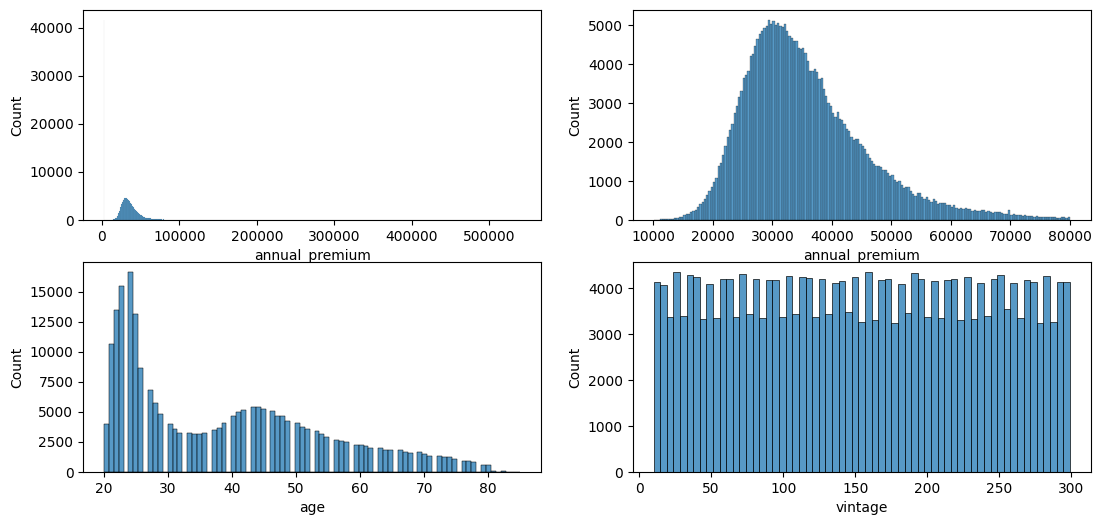

In [383]:
rcParams['figure.figsize'] = 13,6

plt.subplot(2,2,1)
sns.histplot(df5['annual_premium']);

plt.subplot(2,2,2)
aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']        
sns.histplot(aux00);

plt.subplot(2,2,3)
sns.histplot(df5['age']); 

plt.subplot(2,2,4)
sns.histplot(df5['vintage']);

## **5.1 Standardization**

In [384]:
# ANNUAL_PREMIUM
ss=pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values) 

x_validation['annual_premium']=ss.transform(x_validation[['annual_premium']].values)

## **5.2 Rescaling**

In [385]:
# AGE
mms_age=pp.MinMaxScaler()

df5['age']=mms_age.fit_transform(df5[['age']].values)
x_validation['age']=mms_age.transform(x_validation[['age']].values)

# VINTAGE
mms_vintage=pp.MinMaxScaler()
df5['vintage']=mms_vintage.fit_transform(df5[['vintage']].values)
x_validation['vintage']=mms_vintage.transform(x_validation[['vintage']].values)

## **5.3 Encoder**

In [386]:
# GENDER
df5=pd.get_dummies(df5,prefix='gender',columns=['gender'])
x_validation=pd.get_dummies(x_validation,prefix='gender',columns=['gender'])


# REGION_CODE
target_encode_region_code=df5.groupby('region_code')['response'].mean()
df5['region_code']=df5['region_code'].map(target_encode_region_code) 
x_validation['region_code']=x_validation['region_code'].map(target_encode_region_code) 


# VEHICLE_AGE
df5=pd.get_dummies(df5,prefix='vehicle_age',columns=['vehicle_age'])
x_validation=pd.get_dummies(x_validation,prefix='vehicle_age',columns=['vehicle_age'])


# POLICY_SALES_CHANNEL
fe_policy_sales_channel=df5.groupby('policy_sales_channel').size()/len(df5)  
df5['policy_sales_channel']=df5['policy_sales_channel'].map(fe_policy_sales_channel)
x_validation['policy_sales_channel']=x_validation['policy_sales_channel'].map(fe_policy_sales_channel)


# PREVIOUSLY_INSURED
df5['previously_insured']=df5['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['previously_insured']=x_validation['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)


# DRIVING_LICENSE
df5['driving_license']=df5['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['driving_license']=x_validation['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)


# VEHICLE_DAMAGE
df5['vehicle_damage']=df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['vehicle_damage']=x_validation['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation=x_validation.fillna(0)

# **Step 6 Feature selection**

In [387]:
df6=df5.copy()

## **6.1 Feature importance**

In [23]:
# model definition
forest=en.ExtraTreesClassifier(n_estimators=250,random_state=0,n_jobs=-1) 

# data preparation
x_train_n=df6.drop(['id','response'],axis=1)
y_train_n=y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                         feature  importance
0                        vintage    0.272644
0                 annual_premium    0.244569
0                            age    0.167744
0                    region_code    0.106285
0                 vehicle_damage    0.073512
0           policy_sales_channel    0.061830
0             previously_insured    0.049459
0       vehicle_age_below_1_year    0.012883
0  vehicle_age_between_1_2_years    0.006383
0       vehicle_age_over_2_years    0.002438
0                  gender_Female    0.000888
0                    gender_Male    0.000886
0                driving_license    0.000479


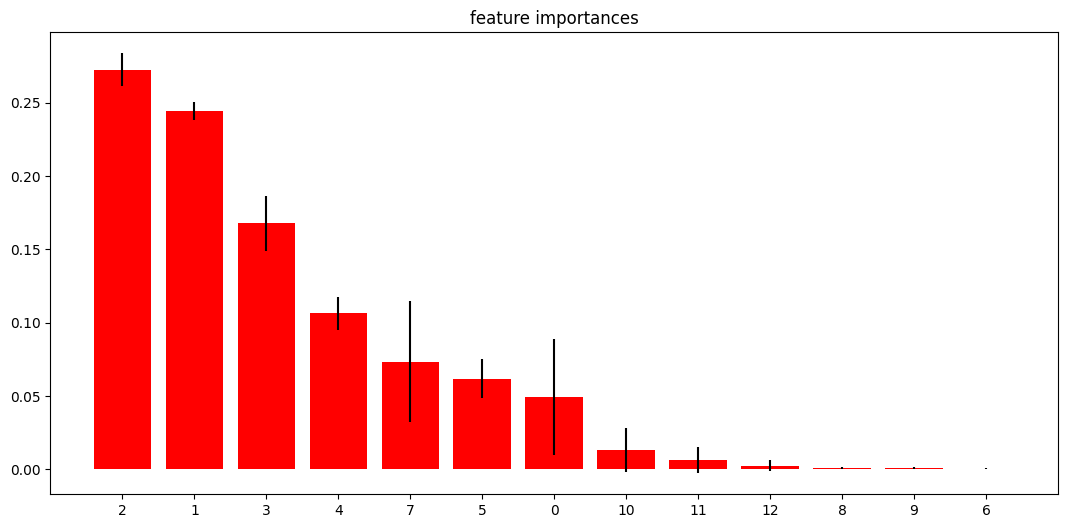

In [24]:
importances=forest.feature_importances_
std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices=np.argsort(importances)[::-1]  

# print the feature ranking
print('Feature ranking')
df=pd.DataFrame()
for i, j in zip(x_train_n,forest.feature_importances_): 
    aux=pd.DataFrame({'feature':i,'importance':j},index=[0])
    df=pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

# plot the imputiry-based feature importances of the forest
plt.figure()
plt.title('feature importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

# **Step 7 Machine learning**

In [388]:
df7=df6.copy()

In [389]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df7[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation

## **7.1 Logistic regression**

Precision at 20% 0.28708637589632263 

Precision at 50% 0.196316120906801 

Recall at 20% 0.5827991452991453 

Recall at 50% 0.999198717948718 



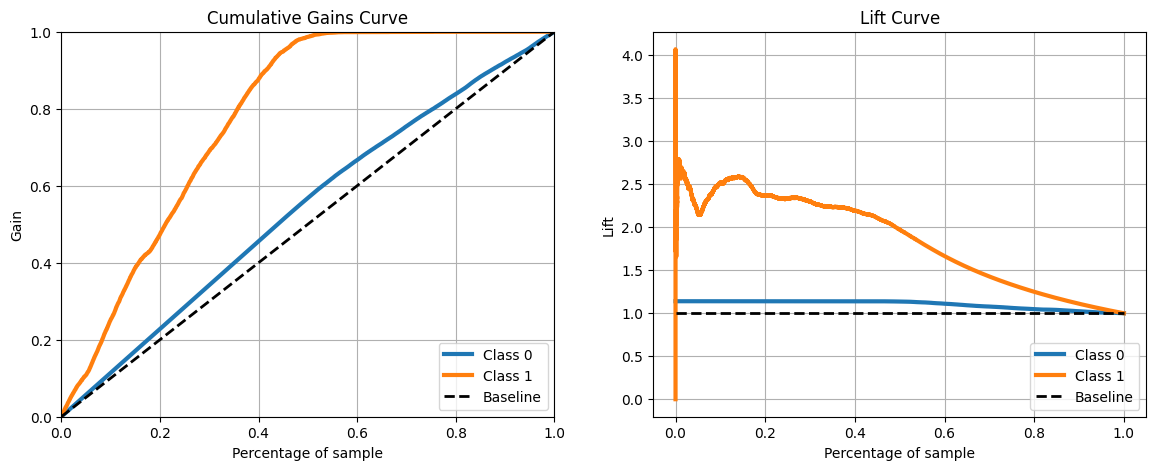

In [15]:
# model definition
lr=lm.LogisticRegression(random_state=42)

# model training
lr.fit(x_train,y_train)

# model prediction
yhat_lr=lr.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lr, data = precision_at_k( df, k=15200 )
precision_at_50_lr, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_lr}','\n')
print(f'Precision at 50% {precision_at_50_lr}','\n')

# compute recall at k
recall_at_20_lr, data = recall_at_k( df, k=15200 )
recall_at_50_lr, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_lr}','\n')
print(f'Recall at 50% {recall_at_50_lr}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lr,ax=ax2 );

### 7.1.1 Logistic regression - Cross validation

Precision at 20% 0.2839736967252095 

Precision at 50% 0.19456197317065171 

Recall at 20% 0.5830836055086029 

Recall at 50% 0.9986868244722045 



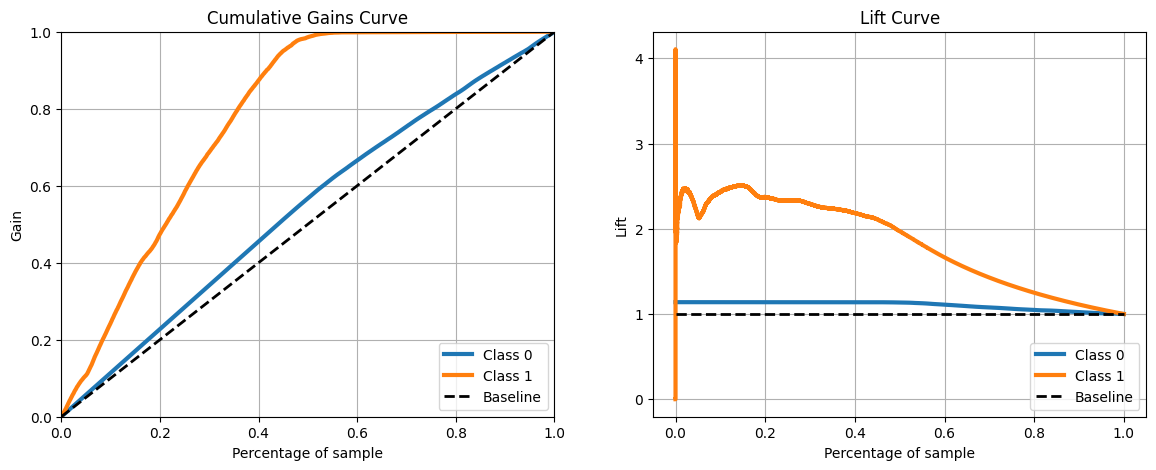

In [16]:
lr_cv = cross_val_predict(lr, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = lr_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lrcv, data = precision_at_k( df, k=60980 )
precision_at_50_lrcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_lrcv}','\n')
print(f'Precision at 50% {precision_at_50_lrcv}','\n')

# compute recall at k
recall_at_20_lrcv, data = recall_at_k( df, k=60980 )
recall_at_50_lrcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_lrcv}','\n')
print(f'Recall at 50% {recall_at_50_lrcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,lr_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, lr_cv,ax=ax2 );

## **7.2 Knn**

Precision at 20% 0.2814288533649102 

Precision at 50% 0.1705237195633921 

Recall at 20% 0.5713141025641025 

Recall at 50% 0.8679220085470085 



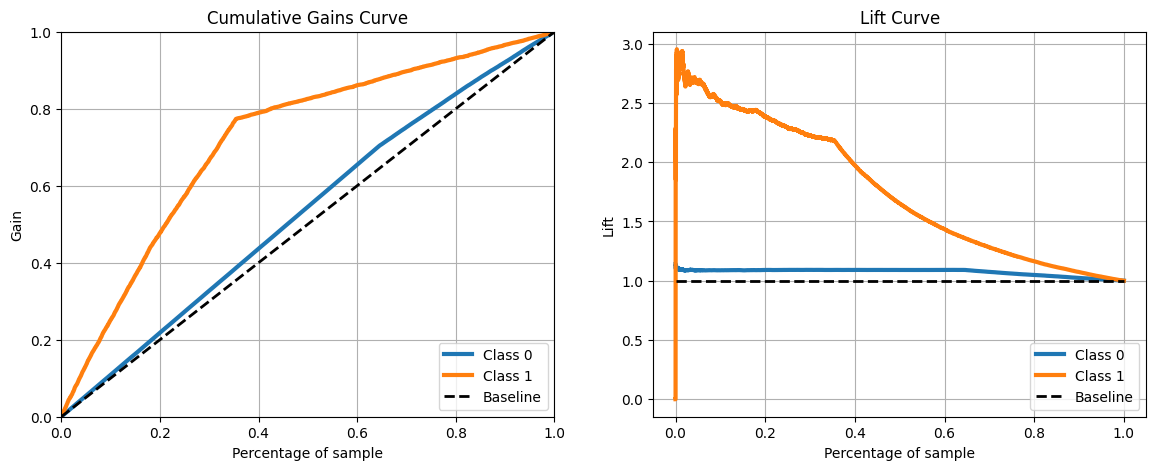

In [17]:
# model definition
knn=nh.KNeighborsClassifier(n_jobs=-1)

# model training
knn.fit(x_train,y_train)

# model prediction
yhat_knn=knn.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_knn, data = precision_at_k( df, k=15200 )
precision_at_50_knn, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_knn}','\n')
print(f'Precision at 50% {precision_at_50_knn}','\n')

# compute recall at k
recall_at_20_knn, data = recall_at_k( df, k=15200 )
recall_at_50_knn, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_knn}','\n')
print(f'Recall at 50% {recall_at_50_knn}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_knn,ax=ax2 );

### 7.2.1 KNN - Cross validation

Precision at 20% 0.27952968957544155 

Precision at 50% 0.17019252845288466 

Recall at 20% 0.5739587191487929 

Recall at 50% 0.8735984376578336 



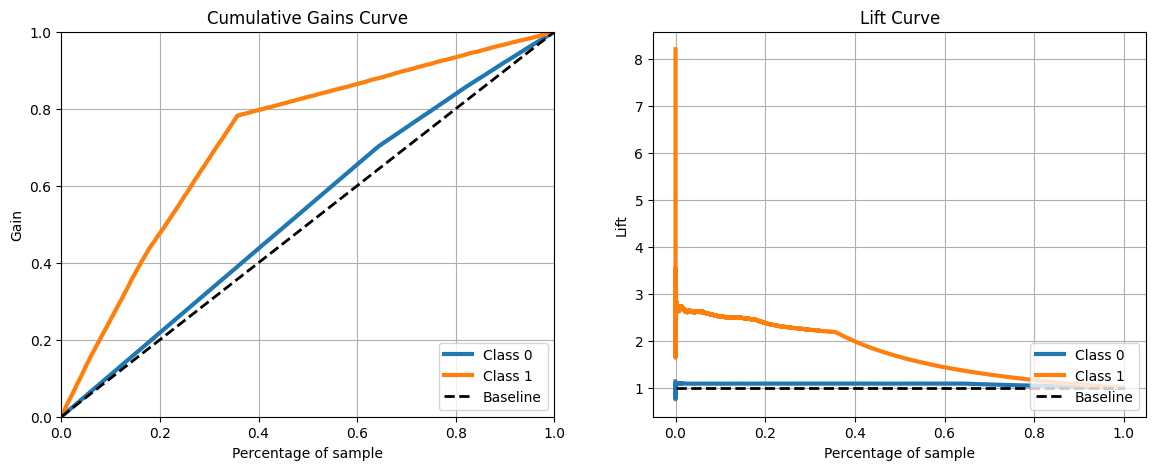

In [18]:
#
knn_cv = cross_val_predict(knn, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = knn_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_knncv, data = precision_at_k( df, k=60980 )
precision_at_50_knncv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_knncv}','\n')
print(f'Precision at 50% {precision_at_50_knncv}','\n')

# compute recall at k
recall_at_20_knncv, data = recall_at_k( df, k=60980 )
recall_at_50_knncv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_knncv}','\n')
print(f'Recall at 50% {recall_at_50_knncv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,knn_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, knn_cv,ax=ax2 );

## **7.3 Extra trees**

Precision at 20% 0.3020196039734228 

Precision at 50% 0.1934823677581864 

Recall at 20% 0.6131143162393162 

Recall at 50% 0.9847756410256411 



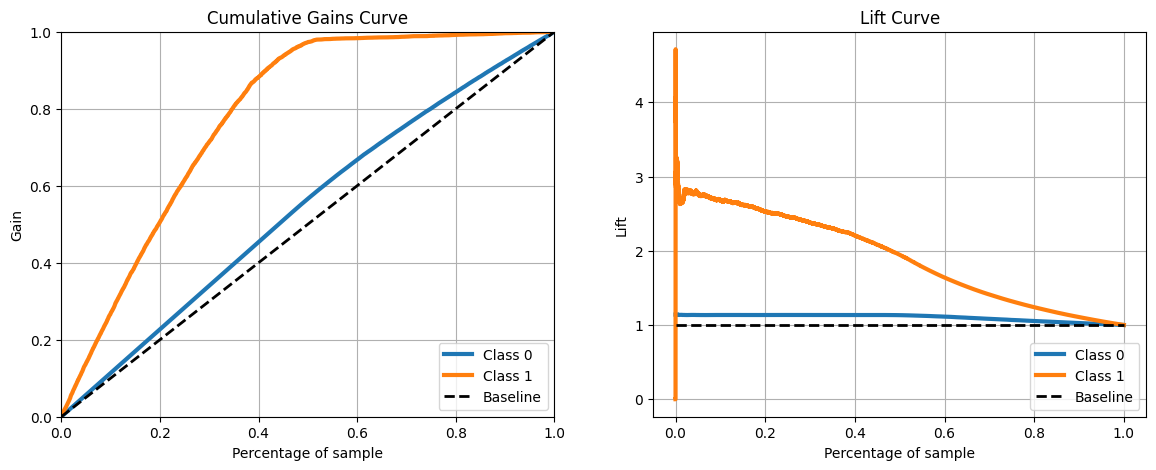

In [19]:
# model definition
et=en.ExtraTreesClassifier(n_jobs=-1,random_state=42)

# model training
et.fit(x_train,y_train)

# model prediction
yhat_et=et.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_et, data = precision_at_k( df, k=15200 )
precision_at_50_et, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_et}','\n')
print(f'Precision at 50% {precision_at_50_et}','\n')

# compute recall at k
recall_at_20_et, data = recall_at_k( df, k=15200 )
recall_at_50_et, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_et}','\n')
print(f'Recall at 50% {recall_at_50_et}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_et,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_et,ax=ax2 );

### 7.3.1 Extra tress - Cross validation

Precision at 20% 0.29930634131942735 

Precision at 50% 0.19208895011315558 

Recall at 20% 0.6145661470083168 

Recall at 50% 0.9859927943701808 



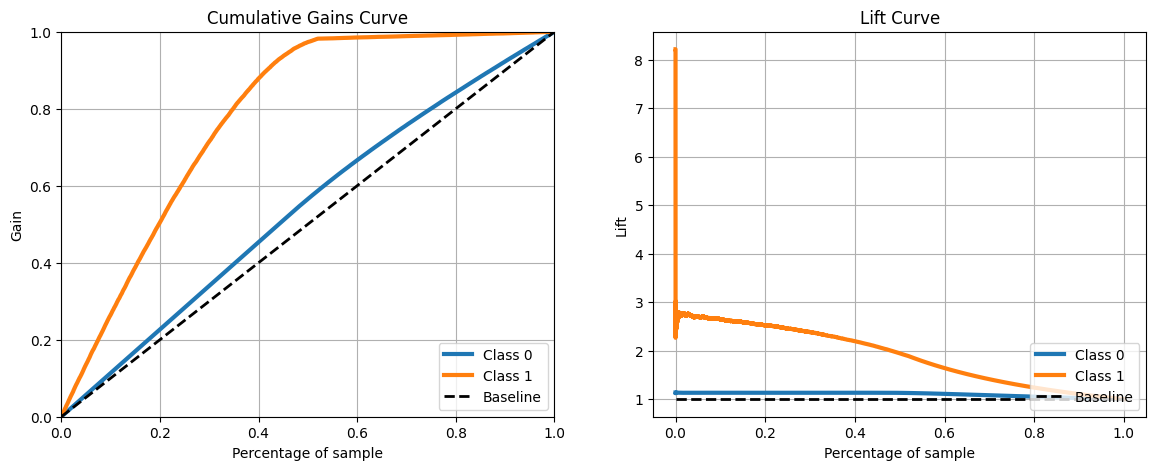

In [20]:
#
et_cv = cross_val_predict(et, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = et_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_etcv, data = precision_at_k( df, k=60980 )
precision_at_50_etcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_etcv}','\n')
print(f'Precision at 50% {precision_at_50_etcv}','\n')

# compute recall at k
recall_at_20_etcv, data = recall_at_k( df, k=60980 )
recall_at_50_etcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_etcv}','\n')
print(f'Recall at 50% {recall_at_50_etcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,et_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, et_cv,ax=ax2 );

## 7.4 Random forest

Precision at 20% 0.3081376225248339 

Precision at 50% 0.19508291351805207 

Recall at 20% 0.625534188034188 

Recall at 50% 0.9929220085470085 



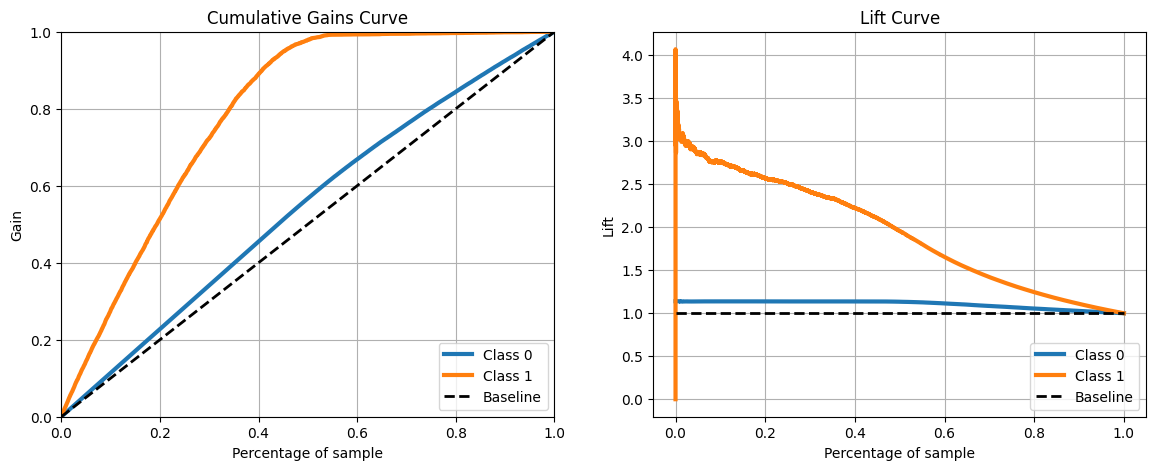

In [21]:
# model definition
rf = en.RandomForestClassifier(n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train,y_train)

# model prediction
yhat_rf=rf.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_rf, data = precision_at_k( df, k=15200 )
precision_at_50_rf, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_rf}','\n')
print(f'Precision at 50% {precision_at_50_rf}','\n')

# compute recall at k
recall_at_20_rf, data = recall_at_k( df, k=15200 )
recall_at_50_rf, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_rf}','\n')
print(f'Recall at 50% {recall_at_50_rf}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_rf,ax=ax2 );

### 7.4.1 Random forest - Cross validation

Precision at 20% 0.3045374788868664 

Precision at 50% 0.19341401817048773 

Recall at 20% 0.6253072494023367 

Recall at 50% 0.9927943701808142 



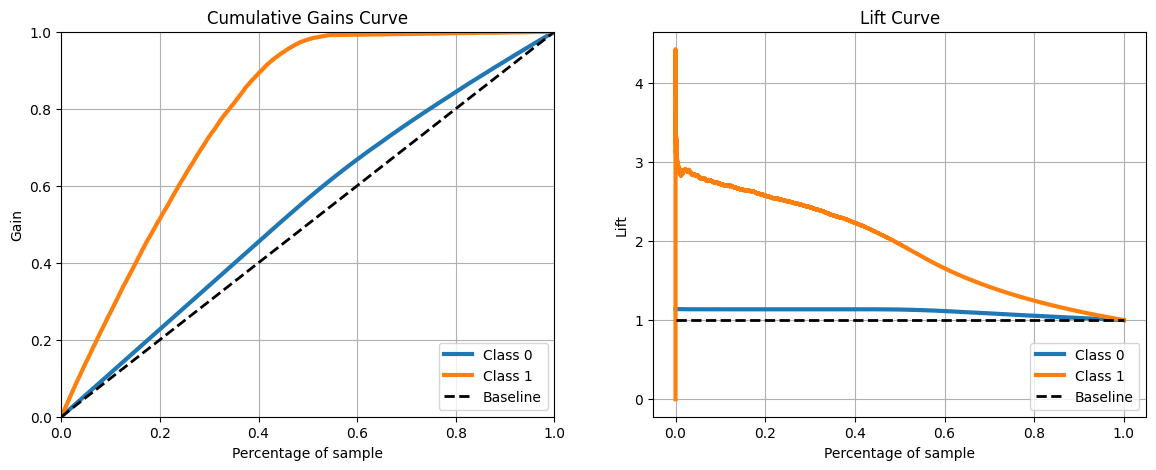

In [22]:
#
rf_cv = cross_val_predict(rf, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = rf_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_rfcv, data = precision_at_k( df, k=60980 )
precision_at_50_rfcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_rfcv}','\n')
print(f'Precision at 50% {precision_at_50_rfcv}','\n')

# compute recall at k
recall_at_20_rfcv, data = recall_at_k( df, k=60980 )
recall_at_50_rfcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_rfcv}','\n')
print(f'Recall at 50% {recall_at_50_rfcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,rf_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, rf_cv,ax=ax2 );

## **7.5 Xgb classifier**

Precision at 20% 0.33320176304190513 

Precision at 50% 0.19623740554156172 

Recall at 20% 0.6764155982905983 

Recall at 50% 0.9987980769230769 



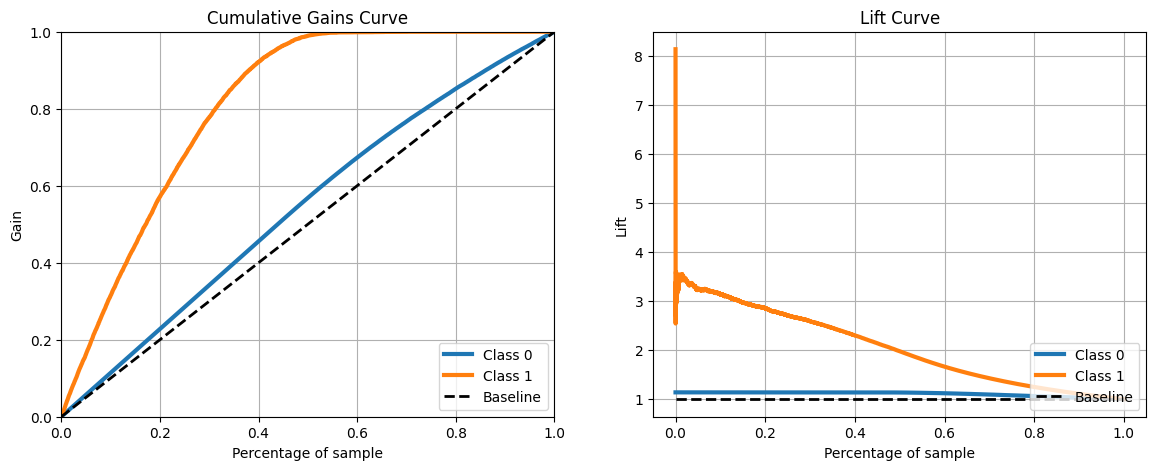

In [23]:
# model definition
xgb_model = xgb.XGBClassifier(n_jobs=-1, random_state=42) 

# model training
xgb_model.fit(x_train,y_train)

# model prediction
yhat_xgb=xgb_model.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_xgb, data = precision_at_k( df, k=15200 )
precision_at_50_xgb, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_xgb}','\n')
print(f'Precision at 50% {precision_at_50_xgb}','\n')

# compute recall at k
recall_at_20_xgb, data = recall_at_k( df, k=15200 )
recall_at_50_xgb, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_xgb}','\n')
print(f'Recall at 50% {recall_at_50_xgb}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_xgb,ax=ax2 );

### **7.6.1 XGB Classifier - Cross validation**

Precision at 20% 0.32982404355454975 

Precision at 50% 0.19456853291350978 

Recall at 20% 0.67722818950133 

Recall at 50% 0.9987204956395839 



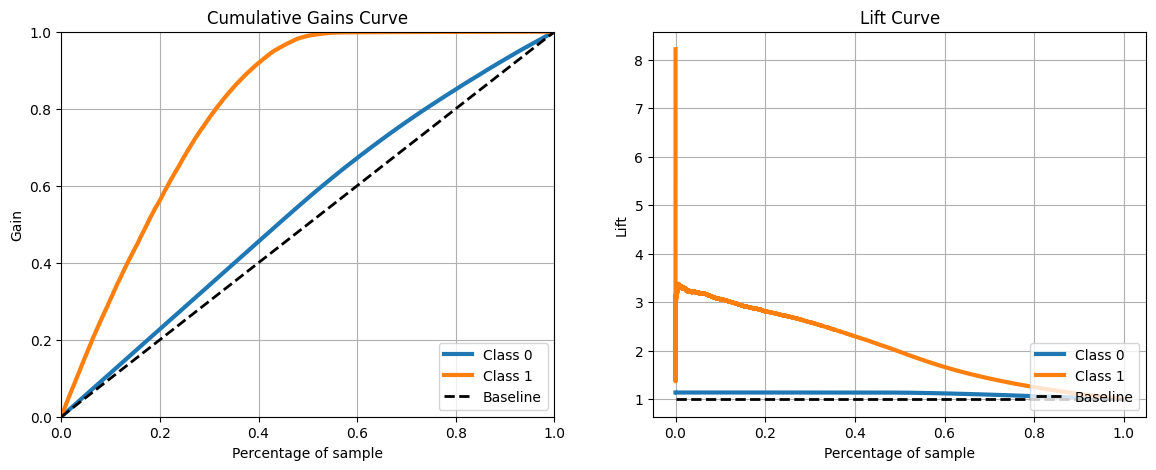

In [24]:
#
xgb_cv = cross_val_predict(xgb_model, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = xgb_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_xgbcv, data = precision_at_k( df, k=60980 )
precision_at_50_xgbcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_xgbcv}','\n')
print(f'Precision at 50% {precision_at_50_xgbcv}','\n')

# compute recall at k
recall_at_20_xgbcv, data = recall_at_k( df, k=60980 )
recall_at_50_xgbcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_xgbcv}','\n')
print(f'Recall at 50% {recall_at_50_xgbcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,xgb_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, xgb_cv,ax=ax2 );

## **7.6 Lgbm classifier**

Precision at 20% 0.33524110255904216 

Precision at 50% 0.196316120906801 

Recall at 20% 0.6805555555555556 

Recall at 50% 0.999198717948718 



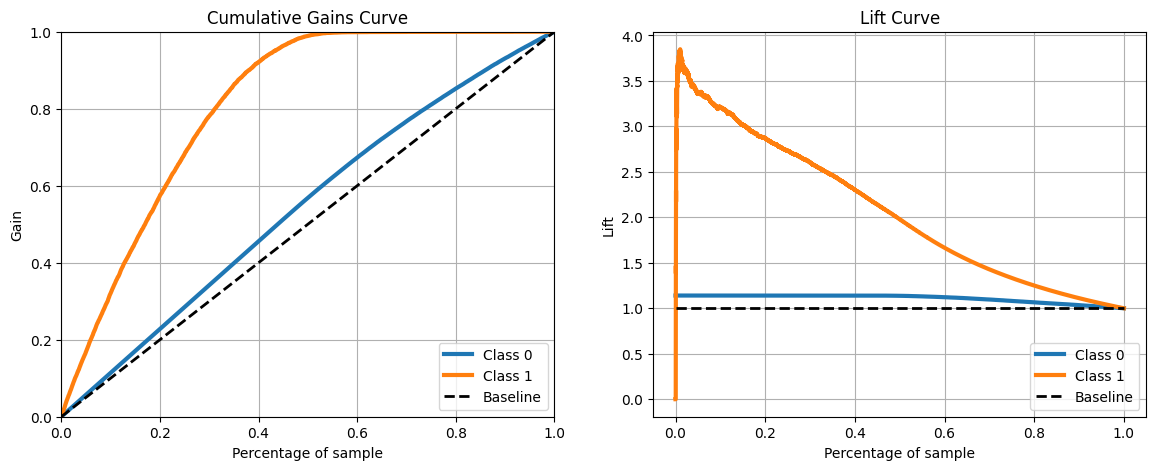

In [25]:
# model definition
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42) 

# model training
lgbm.fit(x_train,y_train)

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lgbm, data = precision_at_k( df, k=15200 )
precision_at_50_lgbm, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20_lgbm}','\n')
print(f'Precision at 50% {precision_at_50_lgbm}','\n')

# compute recall at k
recall_at_20_lgbm, data = recall_at_k( df, k=15200 )
recall_at_50_lgbm, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20_lgbm}','\n')
print(f'Recall at 50% {recall_at_50_lgbm}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

### **7.7.1 LGBM Classifier - Cross validation** 

Precision at 20% 0.33157868844394156 

Precision at 50% 0.19454229394207748 

Recall at 20% 0.6808310044109229 

Recall at 50% 0.9985858109700664 



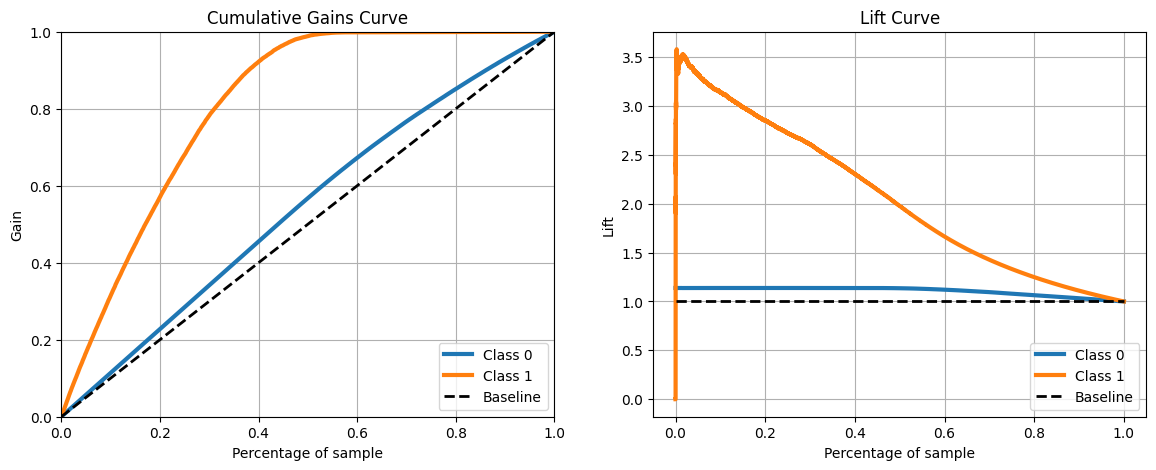

In [26]:
lgbm_cv = cross_val_predict(lgbm, x_train, y_train, cv=5,method='predict_proba')

df = x_train.copy()
df['response'] = y_train.copy()

# propensity score
df['score'] = lgbm_cv[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20_lgbmcv, data = precision_at_k( df, k=60980 )
precision_at_50_lgbmcv, data = precision_at_k( df, k=152444 )
print(f'Precision at 20% {precision_at_20_lgbmcv}','\n')
print(f'Precision at 50% {precision_at_50_lgbmcv}','\n')

# compute recall at k
recall_at_20_lgbmcv, data = recall_at_k( df, k=60980 )
recall_at_50_lgbmcv, data = recall_at_k( df, k=152444 )
print(f'Recall at 20% {recall_at_20_lgbmcv}','\n')
print(f'Recall at 50% {recall_at_50_lgbmcv}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_train,lgbm_cv,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_train, lgbm_cv,ax=ax2 );

## 7.7 Compare performances

###  7.7.1 Cumulative gains curve

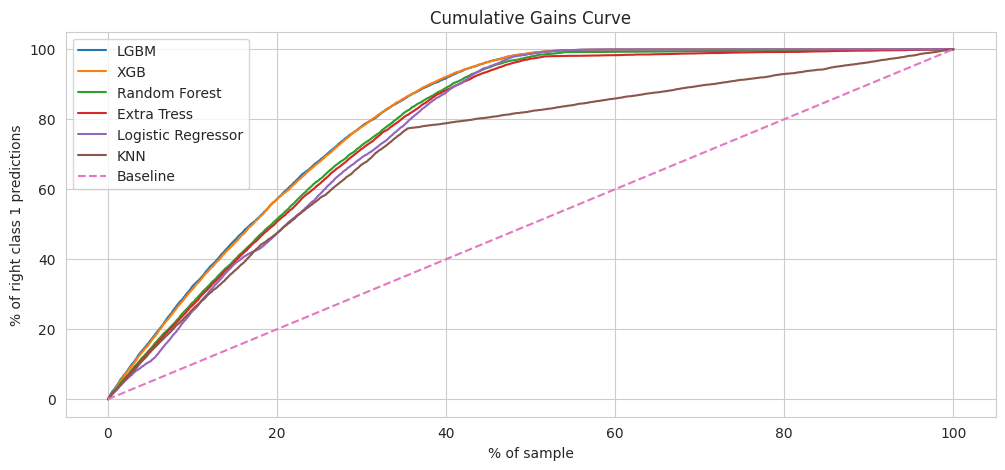

In [33]:
sns.set_style("whitegrid")

rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)
ax1 = plt.subplot(grid[0,0])


# LGBM
lgbm_results = pd.DataFrame()
lgbm_results['prediction'] = yhat_lgbm[:,1].tolist()
lgbm_results['real'] = y_val.tolist()

# ordering by prediction
lgbm_results = lgbm_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lgbm_results['real_cum'] = lgbm_results['real'].cumsum() 
lgbm_results['real_cum_perc'] = 100*lgbm_results['real_cum']/lgbm_results['real'].sum()

# Percentage of Base ( Clients )
lgbm_results['base'] = range( 1, len( lgbm_results ) + 1  )
lgbm_results['base_cum_perc'] = 100*lgbm_results['base']/len( lgbm_results )

# Baseline model
lgbm_results['baseline'] = lgbm_results['base_cum_perc']

# Lift Calculation
lgbm_results['lift'] = lgbm_results['real_cum_perc'] / lgbm_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lgbm_results,ax=ax1,label='LGBM')


# XGB
xgb_results = pd.DataFrame()
xgb_results['prediction'] = yhat_xgb[:,1].tolist()
xgb_results['real'] = y_val.tolist()

# ordering by prediction
xgb_results = xgb_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
xgb_results['real_cum'] = xgb_results['real'].cumsum() 
xgb_results['real_cum_perc'] = 100*xgb_results['real_cum']/xgb_results['real'].sum()

# Percentage of Base ( Clients )
xgb_results['base'] = range( 1, len( xgb_results ) + 1  )
xgb_results['base_cum_perc'] = 100*xgb_results['base']/len( xgb_results )

# Baseline model
xgb_results['baseline'] = xgb_results['base_cum_perc']

# Lift Calculation
xgb_results['lift'] = xgb_results['real_cum_perc'] / xgb_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=xgb_results,ax=ax1,label='XGB')


# RF
rf_results = pd.DataFrame()
rf_results['prediction'] = yhat_rf[:,1].tolist()
rf_results['real'] = y_val.tolist()

# ordering by prediction
rf_results = rf_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
rf_results['real_cum'] = rf_results['real'].cumsum() 
rf_results['real_cum_perc'] = 100*rf_results['real_cum']/rf_results['real'].sum()

# Percentage of Base ( Clients )
rf_results['base'] = range( 1, len( rf_results ) + 1  )
rf_results['base_cum_perc'] = 100*rf_results['base']/len( rf_results )

# Baseline model
rf_results['baseline'] = rf_results['base_cum_perc']

# Lift Calculation
rf_results['lift'] = rf_results['real_cum_perc'] / rf_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=rf_results,ax=ax1,label='Random Forest')


# ET
et_results = pd.DataFrame()
et_results['prediction'] = yhat_et[:,1].tolist()
et_results['real'] = y_val.tolist()

# ordering by prediction
et_results = et_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
et_results['real_cum'] = et_results['real'].cumsum() 
et_results['real_cum_perc'] = 100*et_results['real_cum']/et_results['real'].sum()

# Percentage of Base ( Clients )
et_results['base'] = range( 1, len( et_results ) + 1  )
et_results['base_cum_perc'] = 100*et_results['base']/len( et_results )

# Baseline model
et_results['baseline'] = et_results['base_cum_perc']

# Lift Calculation
et_results['lift'] = et_results['real_cum_perc'] / et_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=et_results,ax=ax1,label='Extra Tress')


# LR
lr_results = pd.DataFrame()
lr_results['prediction'] = yhat_lr[:,1].tolist()
lr_results['real'] = y_val.tolist()

# ordering by prediction
lr_results = lr_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lr_results['real_cum'] = lr_results['real'].cumsum() 
lr_results['real_cum_perc'] = 100*lr_results['real_cum']/lr_results['real'].sum()

# Percentage of Base ( Clients )
lr_results['base'] = range( 1, len( lr_results ) + 1  )
lr_results['base_cum_perc'] = 100*lr_results['base']/len( lr_results )

# Baseline model
lr_results['baseline'] = lr_results['base_cum_perc']

# Lift Calculation
lr_results['lift'] = lr_results['real_cum_perc'] / lr_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lr_results,ax=ax1,label='Logistic Regressor')


# KNN
knn_results = pd.DataFrame()
knn_results['prediction'] = yhat_knn[:,1].tolist()
knn_results['real'] = y_val.tolist()

# ordering by prediction
knn_results = knn_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
knn_results['real_cum'] = knn_results['real'].cumsum() 
knn_results['real_cum_perc'] = 100*knn_results['real_cum']/knn_results['real'].sum()

# Percentage of Base ( Clients )
knn_results['base'] = range( 1, len( knn_results ) + 1  )
knn_results['base_cum_perc'] = 100*knn_results['base']/len( knn_results )

# Baseline model
knn_results['baseline'] = knn_results['base_cum_perc']

# Lift Calculation
knn_results['lift'] = knn_results['real_cum_perc'] / knn_results['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=knn_results,ax=ax1,label='KNN')

sns.lineplot( x='base_cum_perc', y='baseline', data=lr_results,ax=ax1,label='Baseline',linestyle='--')


ax1.set_title('Cumulative Gains Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('% of right class 1 predictions');

###  7.7.2 Lift curve

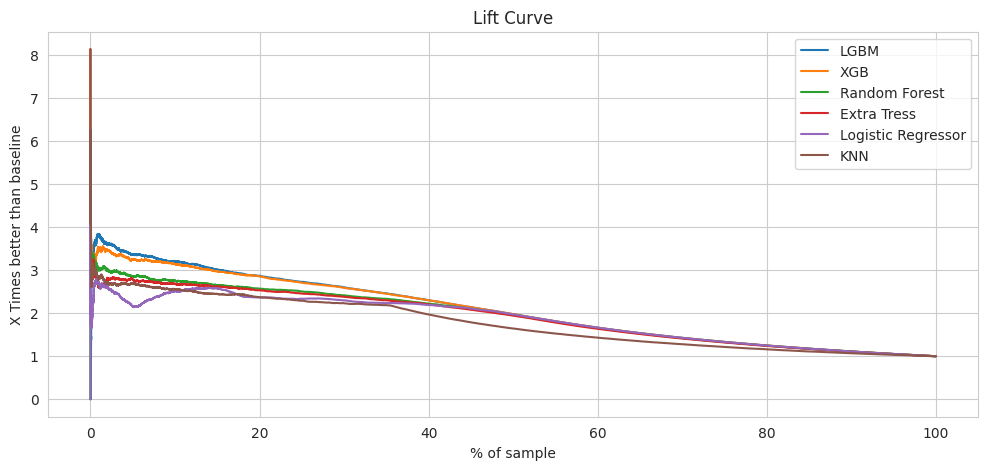

In [65]:
rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)

ax1 = plt.subplot(grid[0,0])

sns.lineplot( x='base_cum_perc', y='lift', data=lgbm_results,ax=ax1,label='LGBM' )

sns.lineplot( x='base_cum_perc', y='lift', data=xgb_results,ax=ax1,label='XGB' )

sns.lineplot( x='base_cum_perc', y='lift', data=rf_results,ax=ax1,label='Random Forest' )

sns.lineplot( x='base_cum_perc', y='lift', data=et_results,ax=ax1,label='Extra Tress' )

sns.lineplot( x='base_cum_perc', y='lift', data=lr_results,ax=ax1,label='Logistic Regressor' )

sns.lineplot( x='base_cum_perc', y='lift', data=knn_results,ax=ax1,label='KNN' )

ax1.set_title('Lift Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('X Times better than baseline');

###  7.7.3 Precision at k and recall at k

In [58]:
res=np.array([[precision_at_20_lgbm,precision_at_50_lgbm,recall_at_20_lgbm,recall_at_50_lgbm],
            [precision_at_20_xgb, precision_at_50_xgb, recall_at_20_xgb, recall_at_50_xgb],
            [precision_at_20_rf,  precision_at_50_rf,  recall_at_20_rf,  recall_at_50_rf],
            [precision_at_20_et,  precision_at_50_et,  recall_at_20_et,  recall_at_50_et],
            [precision_at_20_knn, precision_at_50_knn, recall_at_20_knn,  recall_at_50_knn],
            [precision_at_20_lr,  precision_at_50_lr,  recall_at_20_lr,  recall_at_50_lr]])

results=pd.DataFrame(res,columns=['precision_at_20','precision_at_50','recall_at_20','recall_at_50'],
                 index=['LGBM','XGB','RF','ET','KNN','LR'])

results

,precision_at_20,precision_at_50,recall_at_20,recall_at_50
LGBM,0.335241,0.196316,0.680556,0.999199
XGB,0.333202,0.196237,0.676416,0.998798
RF,0.308138,0.195083,0.625534,0.992922
ET,0.302020,0.193482,0.613114,0.984776
KNN,0.281429,0.170524,0.571314,0.867922
LR,0.287086,0.196316,0.582799,0.999199


In [70]:
print('Best precision at 20%:')
print(results['precision_at_20'].sort_values(ascending=False).to_string())

Best precision at 20%:
LGBM    0.335241
XGB     0.333202
RF      0.308138
ET      0.302020
LR      0.287086
KNN     0.281429


In [69]:
print('Best precision at 50%:')
print(results['precision_at_50'].sort_values(ascending=False).to_string())

Best precision at 50%
LGBM    0.196316
LR      0.196316
XGB     0.196237
RF      0.195083
ET      0.193482
KNN     0.170524


In [71]:
print('Best recall at 20%:')
print(results['recall_at_20'].sort_values(ascending=False).to_string())

Best recall at 20%
LGBM    0.680556
XGB     0.676416
RF      0.625534
ET      0.613114
LR      0.582799
KNN     0.571314


In [72]:
print('Best recall at 50%:')
print(results['recall_at_50'].sort_values(ascending=False).to_string())

Best recall at 50%:
LGBM    0.999199
LR      0.999199
XGB     0.998798
RF      0.992922
ET      0.984776
KNN     0.867922


## **7.8 Compare cross validation performances**

### 7.8.1 Cumulative gains curve

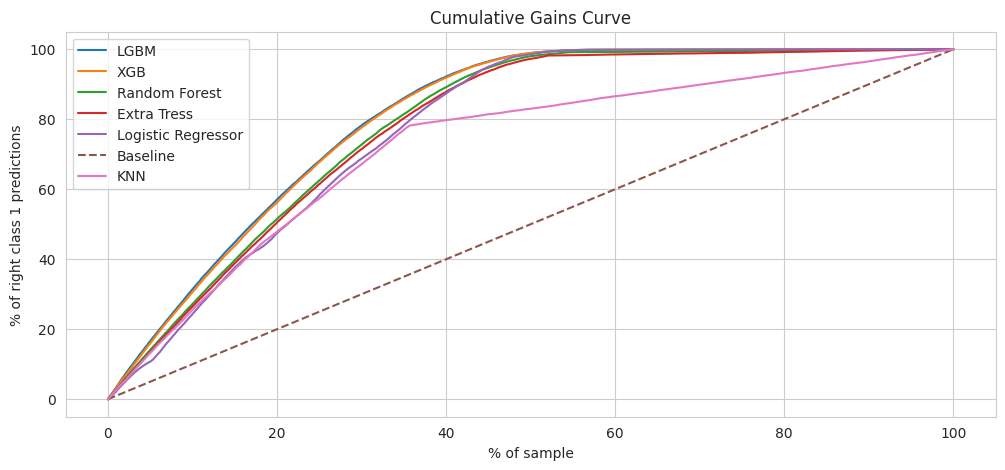

In [46]:
sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)
ax1 = plt.subplot(grid[0,0])


# LGBM
lgbm_results_cv = pd.DataFrame()
lgbm_results_cv['prediction'] = lgbm_cv[:,1].tolist()
lgbm_results_cv['real'] = y_train.tolist()

# ordering by prediction
lgbm_results_cv = lgbm_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lgbm_results_cv['real_cum'] = lgbm_results_cv['real'].cumsum() 
lgbm_results_cv['real_cum_perc'] = 100*lgbm_results_cv['real_cum']/lgbm_results_cv['real'].sum()

# Percentage of Base ( Clients )
lgbm_results_cv['base'] = range( 1, len( lgbm_results_cv ) + 1  )
lgbm_results_cv['base_cum_perc'] = 100*lgbm_results_cv['base']/len( lgbm_results_cv )

# Baseline model
lgbm_results_cv['baseline'] = lgbm_results_cv['base_cum_perc']

# Lift Calculation
lgbm_results_cv['lift'] = lgbm_results_cv['real_cum_perc'] / lgbm_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lgbm_results_cv,ax=ax1,label='LGBM')


# XGB
xgb_results_cv = pd.DataFrame()
xgb_results_cv['prediction'] = xgb_cv[:,1].tolist()
xgb_results_cv['real'] = y_train.tolist()

# ordering by prediction
xgb_results_cv = xgb_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
xgb_results_cv['real_cum'] = xgb_results_cv['real'].cumsum() 
xgb_results_cv['real_cum_perc'] = 100*xgb_results_cv['real_cum']/xgb_results_cv['real'].sum()

# Percentage of Base ( Clients )
xgb_results_cv['base'] = range( 1, len( xgb_results_cv ) + 1  )
xgb_results_cv['base_cum_perc'] = 100*xgb_results_cv['base']/len( xgb_results_cv )

# Baseline model
xgb_results_cv['baseline'] = xgb_results_cv['base_cum_perc']

# Lift Calculation
xgb_results_cv['lift'] = xgb_results_cv['real_cum_perc'] / xgb_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=xgb_results_cv,ax=ax1,label='XGB')


# RF
rf_results_cv = pd.DataFrame()
rf_results_cv['prediction'] = rf_cv[:,1].tolist()
rf_results_cv['real'] = y_train.tolist()

# ordering by prediction
rf_results_cv = rf_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
rf_results_cv['real_cum'] = rf_results_cv['real'].cumsum() 
rf_results_cv['real_cum_perc'] = 100*rf_results_cv['real_cum']/rf_results_cv['real'].sum()

# Percentage of Base ( Clients )
rf_results_cv['base'] = range( 1, len( rf_results_cv ) + 1  )
rf_results_cv['base_cum_perc'] = 100*rf_results_cv['base']/len( rf_results_cv )

# Baseline model
rf_results_cv['baseline'] = rf_results_cv['base_cum_perc']

# Lift Calculation
rf_results_cv['lift'] = rf_results_cv['real_cum_perc'] / rf_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=rf_results_cv,ax=ax1,label='Random Forest')


# ET
et_results_cv = pd.DataFrame()
et_results_cv['prediction'] = et_cv[:,1].tolist()
et_results_cv['real'] = y_train.tolist()

# ordering by prediction
et_results_cv = et_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
et_results_cv['real_cum'] = et_results_cv['real'].cumsum() 
et_results_cv['real_cum_perc'] = 100*et_results_cv['real_cum']/et_results_cv['real'].sum()

# Percentage of Base ( Clients )
et_results_cv['base'] = range( 1, len( et_results_cv ) + 1  )
et_results_cv['base_cum_perc'] = 100*et_results_cv['base']/len( et_results_cv )

# Baseline model
et_results_cv['baseline'] = et_results_cv['base_cum_perc']

# Lift Calculation
et_results_cv['lift'] = et_results_cv['real_cum_perc'] / et_results_cv['base_cum_perc']


sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=et_results_cv,ax=ax1,label='Extra Tress')


# LR
lr_results_cv = pd.DataFrame()
lr_results_cv['prediction'] = lr_cv[:,1].tolist()
lr_results_cv['real'] = y_train.tolist()

# ordering by prediction
lr_results_cv = lr_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
lr_results_cv['real_cum'] = lr_results_cv['real'].cumsum() 
lr_results_cv['real_cum_perc'] = 100*lr_results_cv['real_cum']/lr_results_cv['real'].sum()

# Percentage of Base ( Clients )
lr_results_cv['base'] = range( 1, len( lr_results_cv ) + 1  )
lr_results_cv['base_cum_perc'] = 100*lr_results_cv['base']/len( lr_results_cv )

# Baseline model
lr_results_cv['baseline'] = lr_results_cv['base_cum_perc']

# Lift Calculation
lr_results_cv['lift'] = lr_results_cv['real_cum_perc'] / lr_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=lr_results_cv,ax=ax1,label='Logistic Regressor')

sns.lineplot( x='base_cum_perc', y='baseline', data=lr_results_cv,ax=ax1,label='Baseline',linestyle='--')


# KNN
knn_results_cv = pd.DataFrame()
knn_results_cv['prediction'] = knn_cv[:,1].tolist()
knn_results_cv['real'] = y_train.tolist()

# ordering by prediction
knn_results_cv = knn_results_cv.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
knn_results_cv['real_cum'] = knn_results_cv['real'].cumsum() 
knn_results_cv['real_cum_perc'] = 100*knn_results_cv['real_cum']/knn_results_cv['real'].sum()

# Percentage of Base ( Clients )
knn_results_cv['base'] = range( 1, len( knn_results_cv ) + 1  )
knn_results_cv['base_cum_perc'] = 100*knn_results_cv['base']/len( knn_results_cv )

# Baseline model
knn_results_cv['baseline'] = knn_results_cv['base_cum_perc']

# Lift Calculation
knn_results_cv['lift'] = knn_results_cv['real_cum_perc'] / knn_results_cv['base_cum_perc']

sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=knn_results_cv,ax=ax1,label='KNN')

ax1.set_title('Cumulative Gains Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('% of right class 1 predictions');

### 7.8.2 Lift curve

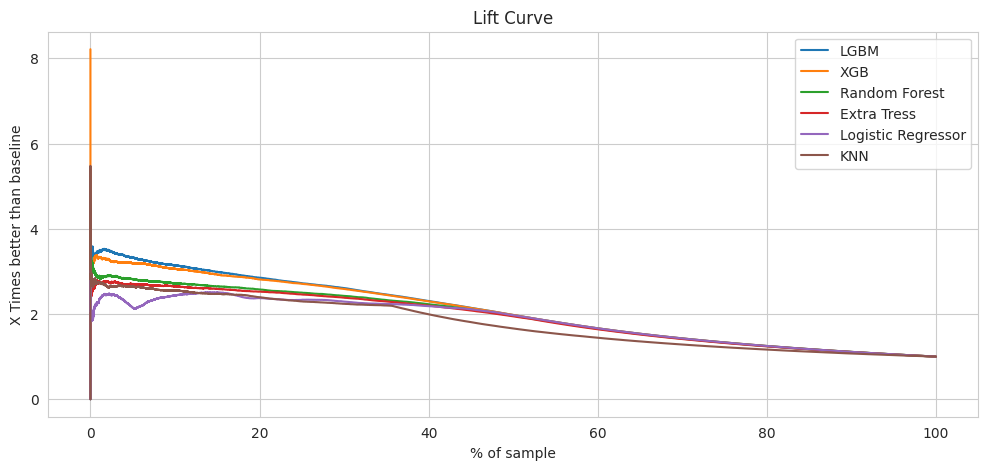

In [63]:
rcParams['figure.figsize'] = 12,5

grid=gridspec.GridSpec(1,1)

ax1 = plt.subplot(grid[0,0])

sns.lineplot( x='base_cum_perc', y='lift', data=lgbm_results_cv,ax=ax1,label='LGBM' )

sns.lineplot( x='base_cum_perc', y='lift', data=xgb_results_cv,ax=ax1,label='XGB' )

sns.lineplot( x='base_cum_perc', y='lift', data=rf_results_cv,ax=ax1,label='Random Forest' )

sns.lineplot( x='base_cum_perc', y='lift', data=et_results_cv,ax=ax1,label='Extra Tress' )

sns.lineplot( x='base_cum_perc', y='lift', data=lr_results_cv,ax=ax1,label='Logistic Regressor' )

sns.lineplot( x='base_cum_perc', y='lift', data=knn_results_cv,ax=ax1,label='KNN' )

ax1.set_title('Lift Curve')
ax1.set_xlabel('% of sample');
ax1.set_ylabel('X Times better than baseline');

### 7.8.3 Precision at k and recall at k

In [57]:
cv_res=np.array([[precision_at_20_lgbmcv,precision_at_50_lgbmcv,recall_at_20_lgbmcv,recall_at_50_lgbmcv],
            [precision_at_20_xgbcv, precision_at_50_xgbcv, recall_at_20_xgbcv, recall_at_50_xgbcv],
            [precision_at_20_rfcv,  precision_at_50_rfcv,  recall_at_20_rfcv,  recall_at_50_rfcv],
            [precision_at_20_etcv,  precision_at_50_etcv,  recall_at_20_etcv,  recall_at_50_etcv],
            [precision_at_20_knncv, precision_at_50_knncv, recall_at_20_knncv,  recall_at_50_knncv],
            [precision_at_20_lrcv,  precision_at_50_lrcv,  recall_at_20_lrcv,  recall_at_50_lrcv]])

cv_results=pd.DataFrame(cv_res,columns=['precision_at_20_cv','precision_at_50_cv','recall_at_20_cv','recall_at_50_cv'],
                 index=['LGBM','XGB','RF','ET','KNN','LR'])

cv_results

,precision_at_20_cv,precision_at_50_cv,recall_at_20_cv,recall_at_50_cv
LGBM,0.331579,0.194542,0.680831,0.998586
XGB,0.329824,0.194569,0.677228,0.998720
RF,0.304537,0.193414,0.625307,0.992794
ET,0.299306,0.192089,0.614566,0.985993
KNN,0.279530,0.170193,0.573959,0.873598
LR,0.283974,0.194562,0.583084,0.998687


In [73]:
print('Best precision at 20%:')
print(cv_results['precision_at_20_cv'].sort_values(ascending=False).to_string())

Best precision at 20%:
LGBM    0.331579
XGB     0.329824
RF      0.304537
ET      0.299306
LR      0.283974
KNN     0.279530


In [74]:
print('Best precision at 50%:')
print(cv_results['precision_at_50_cv'].sort_values(ascending=False).to_string())

Best precision at 50%
XGB     0.194569
LR      0.194562
LGBM    0.194542
RF      0.193414
ET      0.192089
KNN     0.170193


In [75]:
print('Best recall at 20%')
print(cv_results['recall_at_20_cv'].sort_values(ascending=False).to_string())

Best recall at 20%
LGBM    0.680831
XGB     0.677228
RF      0.625307
ET      0.614566
LR      0.583084
KNN     0.573959


In [78]:
print('Best recall at 50%:')
print(cv_results['recall_at_50_cv'].sort_values(ascending=False).to_string())

Best recall at 50%:
XGB     0.998720
LR      0.998687
LGBM    0.998586
RF      0.992794
ET      0.985993
KNN     0.873598


# **Step 8 Final model**

## 8.1 Hyperparameter fine tuning + cross validation

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
{'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 50, 'num_leaves': 40}
Precision at 20% 0.33530688770475625 

Precision at 50% 0.19634235936188077 

Recall at 20% 0.6806891025641025 

Recall at 50% 0.9993322649572649 



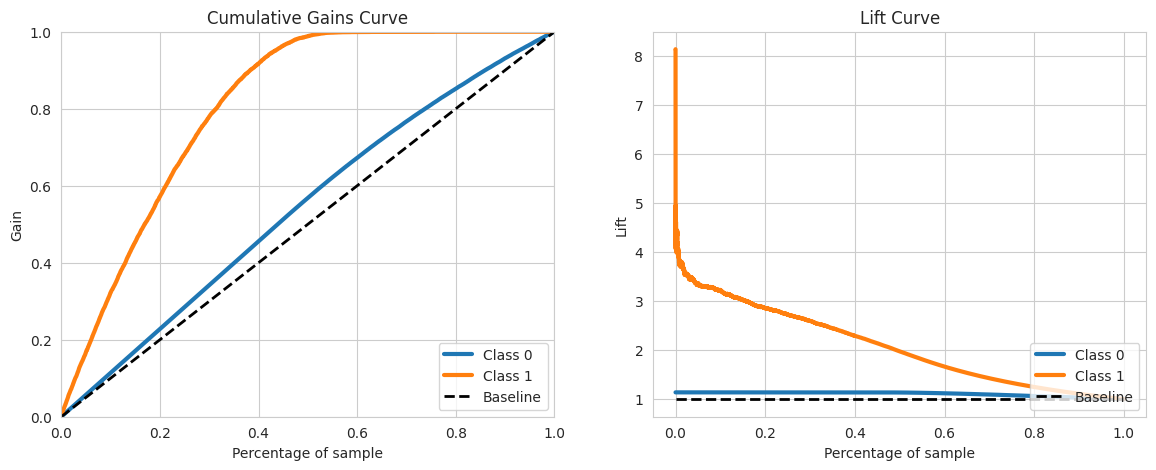

In [30]:
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42, verbose=-2) 


params={'learning_rate': [0.1,0.3],
        'max_depth':[3,12],
        'num_leaves':[40,100],
        'min_data_in_leaf':[50,100]}


lgbm = GridSearchCV(lgbm, param_grid=params,cv=5,n_jobs=-1,verbose=-2)
lgbm.fit(x_train, y_train)
       
print(lgbm.best_params_)    

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);

df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=15200 )
precision_at_50, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=15200 )
recall_at_50, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

## 8.2 Test preparation

In [390]:
x_test=pd.concat ([x_test, y_test], axis=1) 


x_test['vehicle_age']=x_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')

x_test['previously_insured']=x_test['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

x_test['driving_license']=x_test['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')


ss=pp.StandardScaler()
x_test['annual_premium'] = ss.fit_transform(x_test[['annual_premium']].values)

mms_age=pp.MinMaxScaler()
x_test['age']=mms_age.fit_transform(x_test[['age']].values)

mms_vintage=pp.MinMaxScaler()
x_test['vintage']=mms_vintage.fit_transform(x_test[['vintage']].values)


x_test=pd.get_dummies(x_test,prefix='gender',columns=['gender'])

target_encode_region_code=x_test.groupby('region_code')['response'].mean()
x_test['region_code']=x_test['region_code'].map(target_encode_region_code)  

x_test=pd.get_dummies(x_test,prefix='vehicle_age',columns=['vehicle_age'])

fe_policy_sales_channel=x_test.groupby('policy_sales_channel').size()/len(x_test) 
x_test['policy_sales_channel']=x_test['policy_sales_channel'].map(fe_policy_sales_channel)

x_test['previously_insured']=x_test['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['driving_license']=x_test['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)

x_test['vehicle_damage']=x_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

X_test=x_test.fillna(0)

X_test=x_test[cols_selected]

y_test=x_test['response']

## 8.3 Final model

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Precision at 20% 0.3515906854706461 

Precision at 50% 0.2440176322418136 

Recall at 20% 0.5628478420665757 

Recall at 50% 0.9765830095558122 



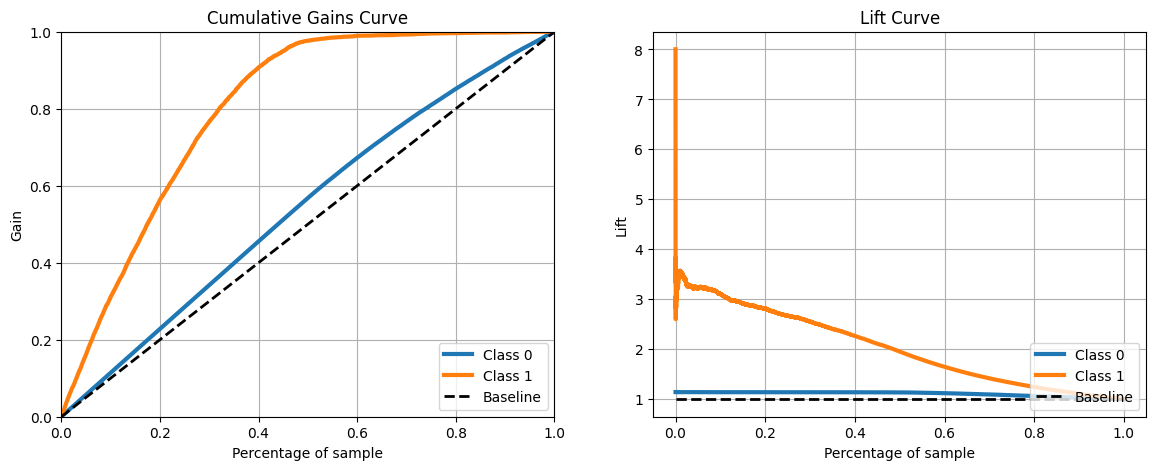

In [391]:
train=pd.concat ([x_train, y_train], axis=1) 

validation=pd.concat ([x_validation, y_validation], axis=1) 

full = pd.merge(train, validation,how='outer')
full_x=full[cols_selected]
full_y=full['response']


# model definition
lgbm_final = lightgbm.LGBMClassifier(learning_rate=0.1, max_depth=3,
                               min_data_in_leaf=50, num_leaves=40, n_jobs=-1, random_state=42,
                                    verbose=-1) 

# model training
lgbm_final.fit(full_x,full_y)

# model prediction
yhat_lgbm_final=lgbm_final.predict_proba(X_test);


df = X_test.copy()
df['response'] = y_test.copy()

# propensity score
df['score'] = yhat_lgbm_final[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=15244 )
precision_at_50, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=15244 )
recall_at_50, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_test,yhat_lgbm_final,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve(y_test, yhat_lgbm_final,ax=ax2);

# test no começo 
# Precision at 20% 0.3602492620531322 

# Precision at 50% 0.24679890848026867 

# Recall at 20% 0.5767090202667227 

# Recall at 50% 0.9877139556862333 


# test no fim 
# Precision at 20% 0.3515906854706461 

# Precision at 50% 0.2440176322418136 

# Recall at 20% 0.5628478420665757 

# Recall at 50% 0.9765830095558122 

# Step 9 Business results

## 9.1 Revenue

In [117]:
# LGBM
results = pd.DataFrame()
results['prediction'] = yhat_lgbm_final[:,1].tolist()
results['real'] = y_test.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
4,0.40,0.400131,639,10227.360382,1.600526,1.000000,10225.759856
3,0.30,0.300031,13123,157492.398855,1.200125,0.600088,157491.198730
2,0.20,0.200080,11201,89643.728901,0.800319,0.300222,89642.928582
1,0.10,0.100076,8763,35078.710019,0.400305,0.100252,35078.309714
0,0.01,0.000231,42496,392.360909,0.000923,0.000231,392.359986


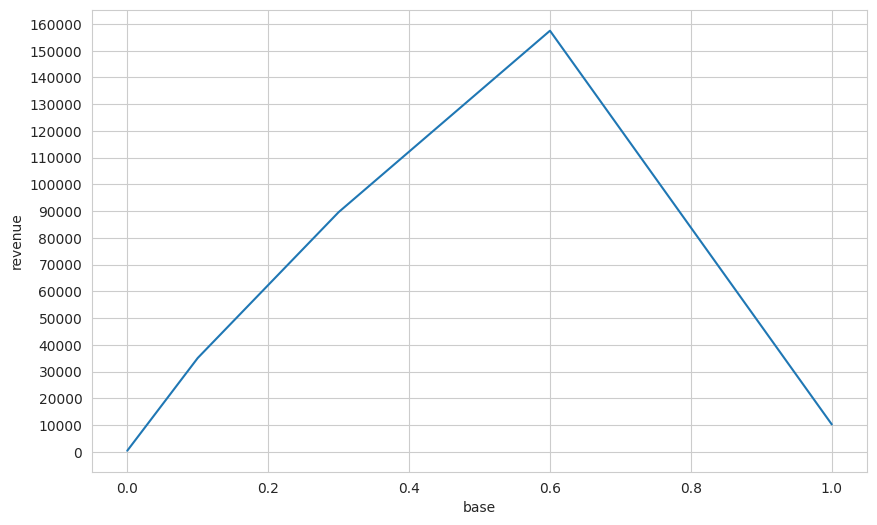

In [142]:
plt.figure( figsize=(10,6))
ax=sns.lineplot( x='base', y='revenue', data=df );
yticks=np.arange(0,160000+1, 10000)
ax.set_yticks(ticks=yticks);

In [76]:
# plt.figure( figsize=(10,6))
# aux = df[df['propensity_score'] >= 0.1]
# sns.lineplot( x='base', y='revenue', data=aux );

## 9.2 Business questions

### 1 - What percentage of customers interested in purchasing auto insurance will the sales team reach by making 20,000 calls?

In [167]:
final_results = pd.DataFrame()
final_results['prediction'] = yhat_lgbm_final[:,1].tolist()
final_results['real'] = y_test.tolist()

# ordering by prediction
final_results = final_results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
final_results['real_cum'] = final_results['real'].cumsum() 
final_results['real_cum_perc'] = 100*final_results['real_cum']/final_results['real'].sum()

# Percentage of Base ( Clients )
final_results['base'] = range( 1, len( final_results ) + 1  )
final_results['base_cum_perc'] = 100*final_results['base']/len( final_results )

final_results=final_results.drop(['prediction','real'],axis=1)

cols_new=['n° of interested', '% of interest', 'calls', 'base %']

final_results.columns=cols_new

final_results[final_results['calls']==20000]

,n° of interested,% of interest,calls,base %
14426,6814,71.553082,20000,26.239144


In [153]:
print('71.55% of interested clients after 20000 calls (26% of the base)')

71.55% of interested clients after 20000 calls (26% of the base)


### 2 - If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to reach?

In [168]:
final_results[final_results['calls']==40000]

,n° of interested,% of interest,calls,base %
47598,9467,99.41195,40000,52.478287


In [156]:
print('99.41% of interested clients after 40000 calls (52% of the base)')

99.41% of interested clients after 40000 calls (52% of the base)


### 3 - How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

In [169]:
final_results[(final_results['base %']>80) & (final_results['base %']<81)].head(1)

,n° of interested,% of interest,calls,base %
56799,9519,99.957996,60978,80.000525


In [158]:
print('23550 calls to reach 80% of interest customers (30% of the base)')

23550 calls to reach 80% of interest customers (30% of the base)


# Step 10 Deploy to production

## 9.1 Health Insurance Class

In [ ]:
class HealthInsurance:
    
    def __init__(self):        
        self.home_path=''
        self.annual_premium_scaler =            pickle.load(open(self.home_path + ''))
        self.age_scaler =                       pickle.load(open(self.home_path + ''))
        self.vintage_scaler =                   pickle.load(open(self.home_path + ''))
#         self.target_encode_gender_scaler =      pickle.load(open(self.home_path + ''))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + '')) 
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + ''))
        
        
    def data_cleaning(df1):        
#         rename columns
        cols_new=['id','gender','age','driving_license','region_code','previously_insured','vehicle_age',
                 'vehicle_damage','annual_premium','policy_sales_channel','vintage','response']
#         rename
        df1.columns=cols_new
    
        return df1
    
    
    def feature_engineering(self,df2):        
#         vehicle damage number
#         df2['vehicle_damage']=df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        df2['previously_insured']=df2['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

        df2['driving_license']=df2['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
#         
#       vehicle age
        df2['vehicle_age']=df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')
    
    
    def data_preparation(df5):       
#         annual_premium - standardscaler
        df5['annual_premium']=self.annual_premium_scaler.transform(df5[['annual_premium']].values)
    
#         age - minmaxScaler
        df5['age']=self.age_scaler.transform(df5[['age']].values)
    
#         vintage - minmaxscaler
        df5['vintage']=self.vintage_scaler.fit_transform(df5[['vintage']].values)
        
#         gender 
#         df5['gender']=df5['gender'].map(self.target_encode_gender_scaler)
        df5=pd.get_dummies(df5,prefix='gender',columns=['gender'])

#         region_code - target encoding
        df5['region_code']=df5['region_code'].map(self.target_encode_region_code_scaler)
    
#         vehicle_age - one hot encoding/frequency encoding
        df5=pd.get_dummies(df5,prefix='vehicle_age',columns=['vehicle_age'])
    
#         policy_sales_channel - frequency encoding
        df5['policy_sales_channel']=df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
    
#         feature selection
        cols_selected=['annual_premium','vintage','age','region_code','vehicle_damage','previously_insured',
                      'policy_sales_channel']
    
        return df5[cols_selected]
    
    
    def get_prediction(self,model,original_data,test_data):   # test_data = produção
#         model prediction
        pred=model.predict_proba(test_data)
    
#         join prediction into original data
        original_data['score']=pred                  # score = prediction
    
        return original_data.to_json(orient='records',date_format='iso')